# VISUALIZATION OF DIFFERENT DATASETS FOR THE DISSERTATION PROJECT

## A. Classification of respiratory patterns in chronic lung conditions through DRC

The dataset is comprised of 2,287,213 observations (1,055,236 observations after removing rows labeled as “NaN” to indicate “not a number”) and 6 variable columns where each observation is unique to a given subject, visit, trial and pair of time series measurement values for flow and volume. The dataset is provided in long format but can be easily pivoted to wide format if that is desired. This is the reasoning for including NaN rows to pad each trial to match the same length of the longest subject’s trial; some software may be easier to pivot the dataset with this padding included while others may prefer to strip these NaN rows. There are a total of 129 subjects present in this dataset as some were unable to achieve complete flow volume loop data with an inspiratory portion (n = 129/137, 94.2% with complete data). The six variables are specifically defined in Table 1. While Table 1 summarizes the dataset as a whole, at the subject level the mean number of trials was 8.2 ± 1.8 trials per subject (across both visits). There are a total of 1972 different trials present in the dataset with 1,004 of these from first test sessions (1,004/1972, 50.9%) and 968 of these from second test sessions (968/1972, 49.1%). A complementary demographics dataset is also provided with one observation per subject (129 rows of data) and demographic measurements as summarized in Table 2 below.

In [103]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [2]:
# Import necessary libraries
from glob import glob
import os
# import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns
import tensorflow as tf

In [ ]:
# Checking the working directory and changing to the one containing the data:
def current_path(): 
    print("Current working directory before")
    print(os.getcwd())
    print()

current_path()
os.chdir(r'c:\Users\Pablo\Desktop\Dissertation project\Datasets\Spirometries from patients')
current_path()


### Calculation of the important parameters which indicate respiratory diseases in the Spirometry records

1. Forced Expiratory Volume in 1st second (FEV1): 

The volume of air forcibly exhaled in the first 1 second after a maximal inhalation. Detect start of forced expiration (usually a sharp change in flow/volume). Measure volume at 1 second from that time point.

2. Forced Vital Capacity (FVC):

The total volume of air exhaled during a forced breath, from full inspiration to end of expiration. Use the same expiration start. FVC is the final exhaled volume.

3. FEV1/FVC Ratio

Proportion of FVC exhaled in the first second.

4. PEF (Peak Expiratory Flow)

The maximum flow rate during forced expiration. Look at the flow-time curve. Find the maximum value in the first part of expiration.

5. FEF25-75% (Forced Expiratory Flow 25–75%)

The average flow during the middle 50% of the FVC.



# Unsupervised learning applied to spirometry recordings for COPD disease detection

In [66]:
# !pip install pyreadstat
# !pip install seaborn
# !pip install scorecardpy
# !pip install association-metrics
# !pip install dython
# !pip install keras_tuner
# !pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 52.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 kB 13.9 MB/s eta 0:00:00

[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip


## Loading the data

In [3]:
# Importing the data as these are SAS files, which are built as tables of data and data structures
# There are in total 3 files, containing spirometry recordings from different patients

import pandas as pd
df1  = pd.read_sas("spxraw_e.sas7bdat", format = "sas7bdat", encoding = "utf-8")
df2  = pd.read_sas("spxraw_f.sas7bdat", format = "sas7bdat", encoding = "utf-8")
df3  = pd.read_sas("spxraw_g.sas7bdat", format = "sas7bdat", encoding = "utf-8")

# Checking the shape of the dataframes
print("Shape of df1:", df1.shape)
print("Shape of df2:", df2.shape)
print("Shape of df3:", df3.shape)

# Print the sum of all the observations: 
print("Sum of the4 total spirometry recordings: ", df1.shape[0] + df2.shape[0] + df3.shape[0])

Shape of df1: (34857, 10)
Shape of df2: (36421, 10)
Shape of df3: (37661, 10)
Sum of the4 total spirometry recordings:  108939


## Exploratory Data Analysis

### Looking for missing and null values

In [4]:
# The following step is to make sure there are no missing values in the dataframes
def missing_values(df):
    return df.isnull().sum().sum() == 0

def count_missing_values(df): 
    return df.isnull().sum().sum()

def count_null_values(df):
    return df.isnull().sum()

def main(): 
    print("Missing values in df1:", count_missing_values(df1))
    print("Missing values in df2:", count_missing_values(df2))
    print("Missing values in df3:", count_missing_values(df3))
    print("Null values in df1:", count_null_values(df1))
    print("Null values in df2:", count_null_values(df2))
    print("Null values in df3:", count_null_values(df3))

if __name__ == "__main__":
    main()
    print("There are no missing values in any dataframe.")

Missing values in df1: 0
Missing values in df2: 0
Missing values in df3: 0
Null values in df1: SEQN        0
SPATTYPE    0
SPAMANU     0
SPAFACT     0
SPAPOS      0
SPAPLAT     0
SPAACC      0
SPAQEFF     0
SPXPTS      0
SPXRAW      0
dtype: int64
Null values in df2: SEQN        0
SPATTYPE    0
SPAMANU     0
SPAFACT     0
SPAPOS      0
SPAPLAT     0
SPAACC      0
SPAQEFF     0
SPXPTS      0
SPXRAW      0
dtype: int64
Null values in df3: SEQN        0
SPATTYPE    0
SPAMANU     0
SPAFACT     0
SPAPOS      0
SPAPLAT     0
SPAACC      0
SPAQEFF     0
SPXPTS      0
SPXRAW      0
dtype: int64
There are no missing values in any dataframe.


### Looking at the datatypes

In [5]:
# The following step consists on feature engineering -> inspect all the datatypes of the dataframes
print(df1.dtypes)
df1.tail()

SEQN        float64
SPATTYPE     object
SPAMANU     float64
SPAFACT     float64
SPAPOS       object
SPAPLAT      object
SPAACC       object
SPAQEFF      object
SPXPTS      float64
SPXRAW       object
dtype: object


SEQN SPATTYPE  SPAMANU  SPAFACT    SPAPOS SPAPLAT SPAACC SPAQEFF  \
34852  51620.0     Bron      3.0    1.085  Standing       Y      Y       A   
34853  51622.0      Pre      1.0    1.080  Standing       N      Y       C   
34854  51622.0      Pre      2.0    1.080  Standing       Y      Y       B   
34855  51622.0      Pre      3.0    1.080  Standing       Y      Y       A   
34856  51622.0      Pre      4.0    1.080  Standing       Y      Y       B   

       SPXPTS                                             SPXRAW  
34852  1271.0  0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...  
34853   179.0  0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,2,2,...  
34854  1012.0  0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...  
34855   926.0  0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...  
34856  1212.0  0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,...

### Univariate analysis

In [5]:
# Merging the 3 dataframes together
df = pd.concat([df1,df2,df3], ignore_index = True)
# Getting the statistical descriptors from the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108939 entries, 0 to 108938
Data columns (total 10 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   SEQN      108939 non-null  float64
 1   SPATTYPE  108939 non-null  object 
 2   SPAMANU   108939 non-null  float64
 3   SPAFACT   108939 non-null  float64
 4   SPAPOS    108939 non-null  object 
 5   SPAPLAT   108939 non-null  object 
 6   SPAACC    108939 non-null  object 
 7   SPAQEFF   108939 non-null  object 
 8   SPXPTS    108939 non-null  float64
 9   SPXRAW    108939 non-null  object 
dtypes: float64(4), object(6)
memory usage: 8.3+ MB


In [75]:
# Getting the statistics behind the numerical data
df[["SPAMANU", "SPAFACT", "SPXPTS"]].describe()[1:8]

SPAMANU   SPAFACT       SPXPTS
mean   3.309696  1.082439   857.002662
std    1.915353  0.011504   411.495369
min    1.000000  1.039000     1.000000
25%    2.000000  1.074000   578.000000
50%    3.000000  1.080000   848.000000
75%    4.000000  1.090000  1097.000000
max   13.000000  1.145000  2044.000000

In [76]:
### Plotting some boxplots about numerical variables

# Taking the numerical variables
numerical_cols = df.select_dtypes(include = ["float64"]).columns.to_list()
# Removing the patient id
numerical_cols.pop(0)

'SEQN'

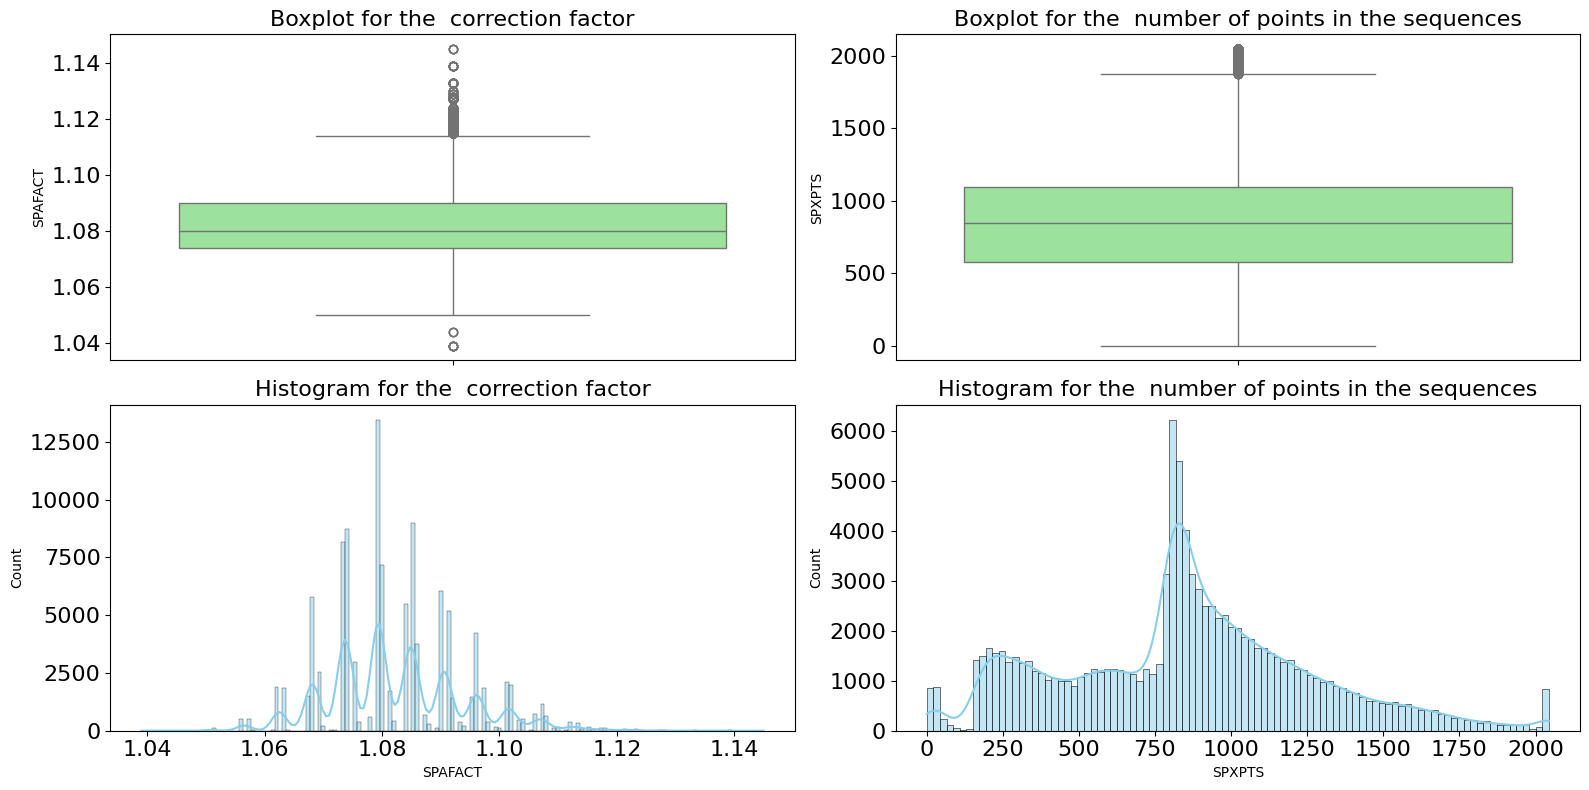

In [8]:
# Plotting the boxplots and the histograms for the numerical variables
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2,2, figsize = (16,8))
axes = axes.flatten()

sns.boxplot(df["SPAFACT"], ax = axes[0], color = "lightgreen")
axes[0].set_title("Boxplot for the  correction factor", fontsize = 16)
axes[0].tick_params(axis='both', labelsize=16)
sns.boxplot(df["SPXPTS"], ax = axes[1], color = "lightgreen")
axes[1].set_title("Boxplot for the  number of points in the sequences", fontsize = 16)
axes[1].tick_params(axis='both', labelsize=16)
sns.histplot(df["SPAFACT"], ax = axes[2], kde = True, color = "skyblue")
axes[2].set_title("Histogram for the  correction factor", fontsize = 16)
axes[2].tick_params(axis='both', labelsize=16)
sns.histplot(df["SPXPTS"], ax = axes[3], kde = True, color = "skyblue")
axes[3].set_title("Histogram for the  number of points in the sequences", fontsize = 16)
axes[3].tick_params(axis='both', labelsize=16)

plt.tight_layout()
plt.show()

In [9]:
# Taking the categorical variables
categorical_cols = df.select_dtypes(include = ["object"]).columns.to_list()
categorical_cols.pop(-1)

'SPXRAW'

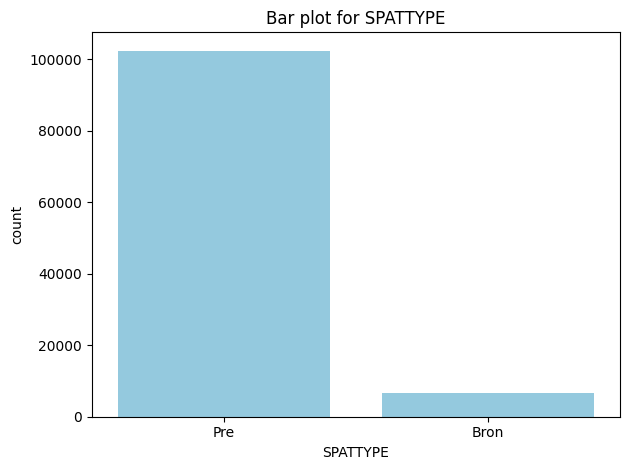

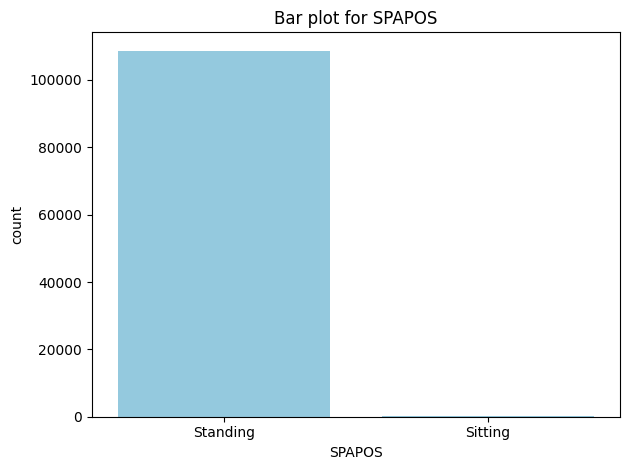

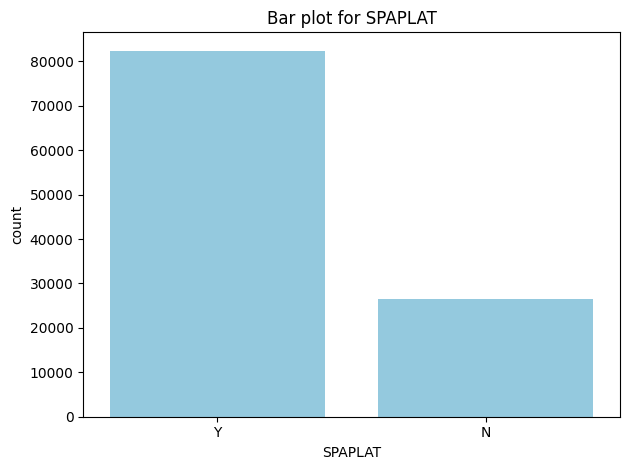

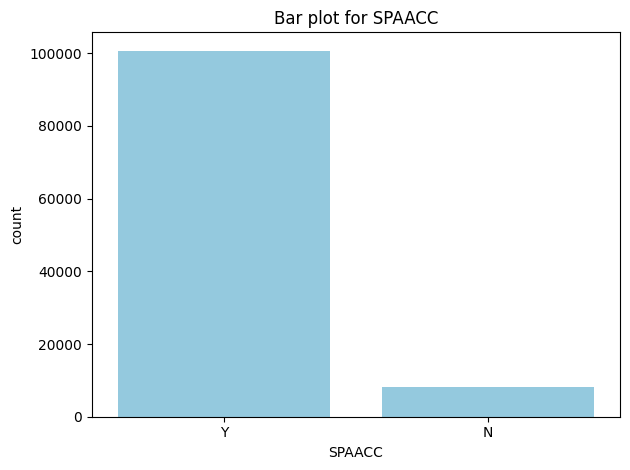

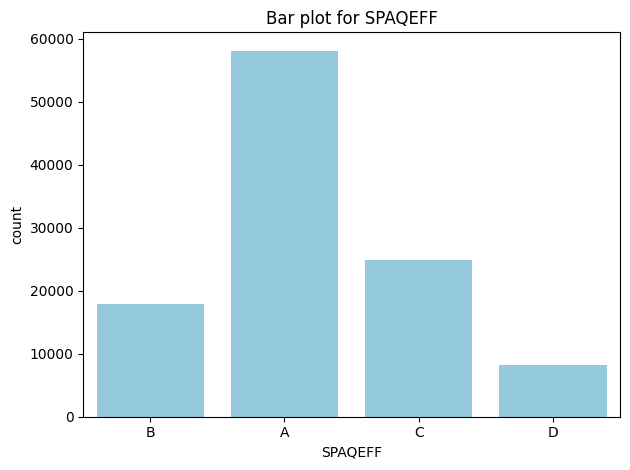

In [10]:
# Plotting the countplots of the categorical vars
for col in categorical_cols: 
    sns.countplot(data = df, x = col, color = "skyblue")
    plt.title("Bar plot for {}".format(col))
    plt.tight_layout()
    plt.show()

In [11]:
# Computing some interesting percentages about the graphs
perc_SPATTYPE = np.round(((df["SPATTYPE"] == "Bron").sum()/df.shape[0])*100)
print("Percentage of trials without prebronchodilator: {}".format(perc_SPATTYPE))
perc_sitting = np.round(((df["SPAPOS"] == "Sitting").sum()/df.shape[0])*100 , 2)
print("Percentage of trials with the sitting position: {}".format(perc_sitting))
perc_plateau = np.round(((df["SPAPLAT"] == "N").sum()/df.shape[0])*100,2)
print("Percentage of expiratory cycles reaching the plateau: {}".format(perc_plateau))
perc_acceptable = np.round(((df["SPAACC"] == "N").sum()/df.shape[0])*100, 2)
print("Percentage of non acceptable maneuvers: {}".format(perc_acceptable))
perc_A = np.round(((df["SPAQEFF"] == "A").sum()/df.shape[0])*100, 2)
print("Percentage of examinee efforts graded with an A: {}".format(perc_A))
perc_B = np.round(((df["SPAQEFF"] == "B").sum()/df.shape[0])*100, 2)
print("Percentage of examinee efforts graded with an B: {}".format(perc_B))

Percentage of trials without prebronchodilator: 6.0
Percentage of trials with the sitting position: 0.2
Percentage of expiratory cycles reaching the plateau: 24.33
Percentage of non acceptable maneuvers: 7.56
Percentage of examinee efforts graded with an A: 53.33
Percentage of examinee efforts graded with an B: 16.35


### Multivariate analysis

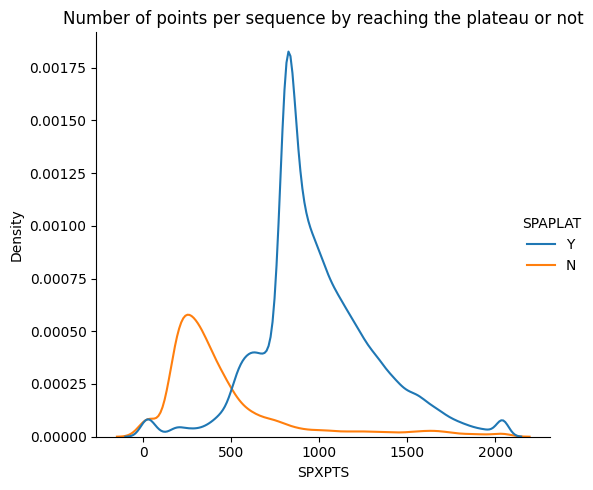

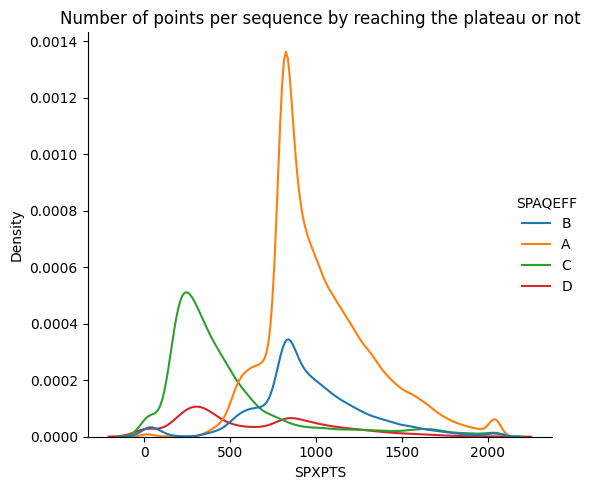

In [12]:
# for col in categorical_cols: 
#     sns.displot(data = df, x = "SPXPTS", hue = col, kind = "kde")
#     plt.title("Density plot of SPXPTS by {}".format(col)) 
#     plt.tight_layout()
#     plt.show()

sns.displot(data = df, x = "SPXPTS", hue = "SPAPLAT", kind = "kde")
plt.title("Number of points per sequence by reaching the plateau or not")
plt.tight_layout()
plt.show()

sns.displot(data = df, x = "SPXPTS", hue = "SPAQEFF", kind = "kde")
plt.title("Number of points per sequence by reaching the plateau or not")
plt.tight_layout()
plt.show()

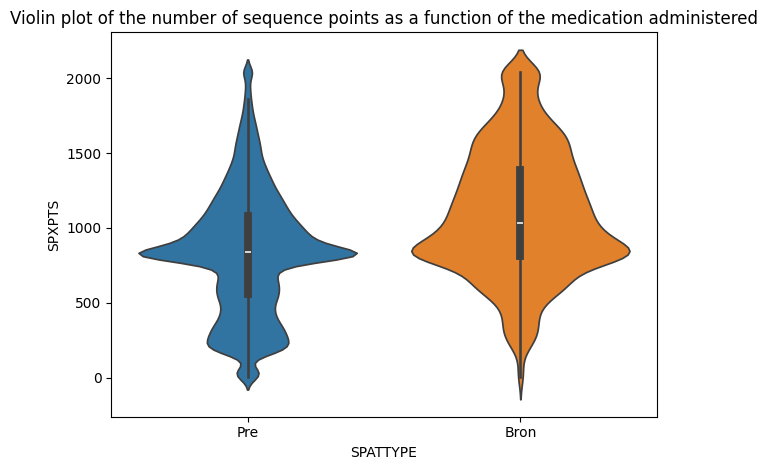

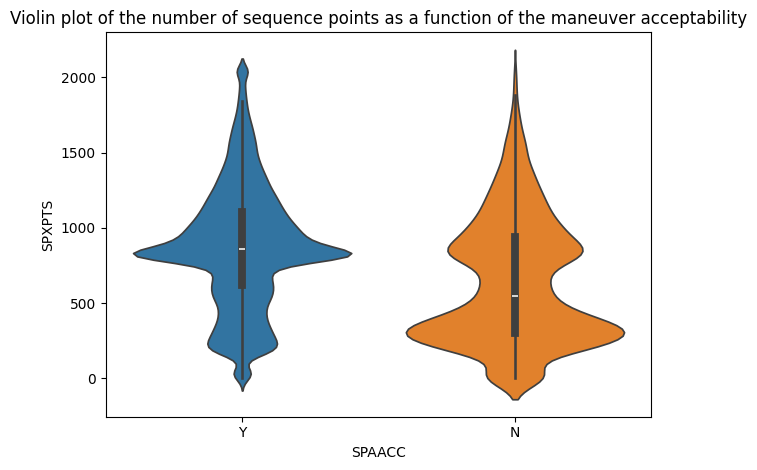

In [13]:
# Plotting the violinplots for other categorical variables

sns.violinplot(data = df, x = "SPATTYPE", y = "SPXPTS", hue = "SPATTYPE")
plt.title("Violin plot of the number of sequence points as a function of the medication administered")
plt.tight_layout()
plt.show()

sns.violinplot(data = df, x = "SPAACC", y = "SPXPTS", hue = "SPAACC")
plt.title("Violin plot of the number of sequence points as a function of the maneuver acceptability")
plt.tight_layout()
plt.show()

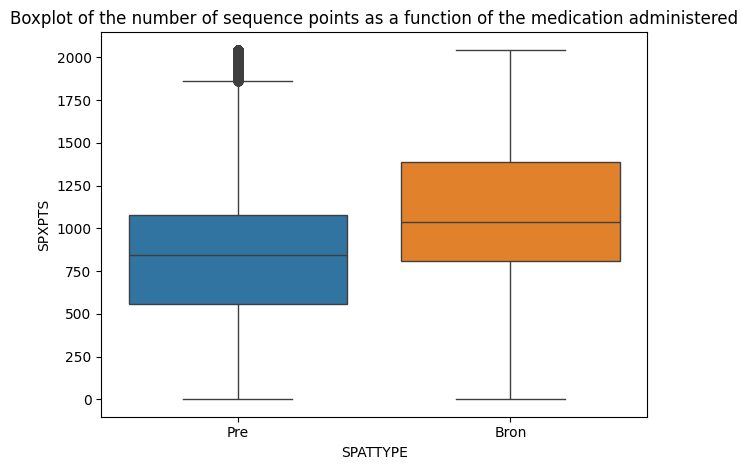

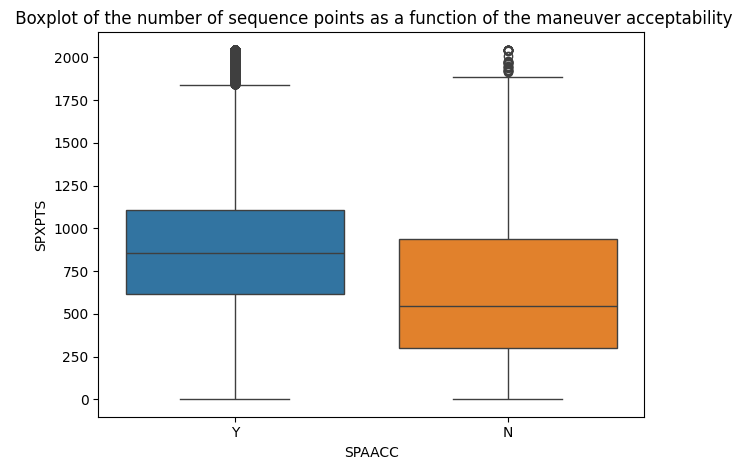

In [14]:
# PLotting the boxplots for the number of points as a function of some categorical vars

sns.boxplot(data = df, x = "SPATTYPE", y = "SPXPTS", hue = "SPATTYPE")
plt.title("Boxplot of the number of sequence points as a function of the medication administered")
plt.tight_layout()
plt.show()

sns.boxplot(data = df, x = "SPAACC", y = "SPXPTS", hue = "SPAACC")
plt.title(" Boxplot of the number of sequence points as a function of the maneuver acceptability")
plt.tight_layout()
plt.show()

In [15]:
# Looking for the correlation between the numerical vars:
from scipy.stats import pearsonr, spearmanr

# Computing the pearson correlation
pearson_correlation = pearsonr(df['SPAFACT'], df['SPXPTS'])
print("The pearson correlation between the number of sequence points and the correction factor is {}".format(str(np.round(pearson_correlation[0], 4))))

# Computing the spearman correlation
spearman_correlation = spearmanr(df['SPAFACT'], df['SPXPTS'])
print("The spearman correlation between the number of sequence points and the correction factor is {}".format(str(np.round(spearman_correlation[0], 4))))

# ['SPAFACT', 'SPXPTS']

The pearson correlation between the number of sequence points and the correction factor is 0.0041
The spearman correlation between the number of sequence points and the correction factor is 0.0002


In [ ]:
# Checking the correlations between the catrgorical variables
import scipy.stats as ss

df_categ = df[categorical_cols] 

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

df_categ_cols = df[categorical_cols].columns
corr_matrix = pd.DataFrame(index=df_categ_cols, columns=df_categ_cols)

for col1 in df_categ_cols:
    for col2 in df_categ_cols:
        corr_matrix.loc[col1, col2] = cramers_v(df[col1], df[col2])

corr_matrix = corr_matrix.astype(float)

# Plotting the heatmap for the correlation between the categorical vars
plt.figure(figsize = (16,8))
sns.heatmap(corr_matrix, annot = True, cmap = "coolwarm", annot_kws={"size": 18})
plt.title("Heatmap of correlations with Cramér's of categorical variables", fontsize = 16)
plt.tight_layout()
plt.show()
    

In [ ]:
df.head()

### Datasets description

For NHANES 2007-08 Spirometry data, the overall summary best test results for the most frequently used spirometric parameters are provided in the dataset SPX_E. This data should be sufficient for most analytic purposes. Advanced data analysts, however, may wish to use the raw, unedited spirometry curve data for modeling the NHANES 2007-08 Spirometry data. The dataset SPXRAW_E provides this raw spirometry curve data.

Participants eligible for spirometry performed an initial or "baseline" 1st test spirometry examination. If certain criteria were met, a subset of participants then performed a repeat 2nd test spirometry exam after inhaling a β2-adrenergic bronchodilator. Multiple individual spirometry curves were typically obtained during both the 1st and 2nd test spirometry examinations. SPXRAW_E contains the raw data for all of these individual spirometry curves.

For each individual curve that was performed, the SPXRAW_E dataset contains the administrative variables listed below plus the variable SPXRAW which contains the data points needed to plot each curve. Since this is a release of raw curve data, no editing was performed for the public release dataset.

It is important to understand which are the most relevant features in the tables: 

- SEQN	 Respondent Sequence Number
- SPATTYPE	 Type of Test: Pre- or Post-Bronchodilator Test
- SPAMANU	 Spirometry Curve Number
- SPAFACT	 BPTS Correction Factor
- SPAPOS	 Testing Position (Standing/Sitting)
- PAPLAT	 Plateau Achieved (Individual Raw Curve)
- SPAACC	 Acceptable Maneuver (Individual Raw Curve)
- SPAQEFF	 Examinee Effort (Individual Raw Curve)
- SPXPTS	 Number of data points in individual raw spirometry curve
- SPXRAW	 Comma-delimited raw spirometry curve data

### Preprocessing and data integration

In [6]:
# The following step is to make sure there are no missing values in the dataframes
def missing_values(df):
    return df.isnull().sum().sum() == 0

def count_missing_values(df): 
    return df.isnull().sum().sum()

def count_null_values(df):
    return df.isnull().sum()

def main(): 
    print("Missing values in df1:", count_missing_values(df1))
    print("Missing values in df2:", count_missing_values(df2))
    print("Missing values in df3:", count_missing_values(df3))
    print("Null values in df1:", count_null_values(df1))
    print("Null values in df2:", count_null_values(df2))
    print("Null values in df3:", count_null_values(df3))

if __name__ == "__main__":
    main()
    print("There are no missing values in any dataframe.")

Missing values in df1: 0
Missing values in df2: 0
Missing values in df3: 0
Null values in df1: SEQN        0
SPATTYPE    0
SPAMANU     0
SPAFACT     0
SPAPOS      0
SPAPLAT     0
SPAACC      0
SPAQEFF     0
SPXPTS      0
SPXRAW      0
dtype: int64
Null values in df2: SEQN        0
SPATTYPE    0
SPAMANU     0
SPAFACT     0
SPAPOS      0
SPAPLAT     0
SPAACC      0
SPAQEFF     0
SPXPTS      0
SPXRAW      0
dtype: int64
Null values in df3: SEQN        0
SPATTYPE    0
SPAMANU     0
SPAFACT     0
SPAPOS      0
SPAPLAT     0
SPAACC      0
SPAQEFF     0
SPXPTS      0
SPXRAW      0
dtype: int64
There are no missing values in any dataframe.


In [7]:
# Checking for duplicates
duplicates = df[df.duplicated(subset =["SEQN", "SPXPTS", "SPXRAW"], keep = False)]
print("The number of duplicated rows is {} .".format(duplicates.shape[0]))
# Removing the duplicates from the dataset
df_clean = df.drop_duplicates(subset = ["SEQN", "SPXPTS", "SPXRAW"])
print(duplicates)

The number of duplicated rows is 138 .
          SEQN SPATTYPE  SPAMANU  SPAFACT    SPAPOS SPAPLAT SPAACC SPAQEFF  \
892    41718.0      Pre      1.0    1.073  Standing       Y      N       D   
893    41718.0      Pre      2.0    1.073  Standing       Y      Y       C   
894    41718.0      Pre      3.0    1.073  Standing       Y      Y       C   
895    41718.0      Pre      4.0    1.073  Standing       Y      Y       C   
896    41718.0      Pre      5.0    1.073  Standing       Y      Y       B   
...        ...      ...      ...      ...       ...     ...    ...     ...   
34473  51488.0      Pre      1.0    1.090  Standing       Y      Y       C   
34474  51488.0      Pre      2.0    1.090  Standing       Y      Y       A   
34475  51488.0      Pre      3.0    1.090  Standing       Y      Y       B   
34476  51488.0      Pre      4.0    1.090  Standing       Y      Y       A   
34477  51488.0      Pre      5.0    1.090  Standing       Y      Y       C   

       SPXPTS SPXRAW  
8

In [8]:
def str_tolist(string): 
    '''Function converting strings of curve values
    to a list containing all the data points.'''
    string = string.replace(",","")
    string = string.replace(" ","")
    sequence = [float(string[0])]+ []
    for i in range (1, len(string)):
        if string[i] == "-":
            value =  int(string[i+1])*(-1)
        else: 
            value = string[i]
        if string[i-1] == "-":
            continue
        sequence.append(float(value))
    return sequence

In [23]:
# Adding the time and the flow to the sequences
freq = 100 
T = 1/freq

def create_time_flow(sequences, period = T): 
    '''This function will compute the time 
    and the flow for every sequence.'''
    time_sequences = [np.arange(len(sequence))*period for sequence in sequences]
    flow_sequences = [np.round(np.gradient(sequence, period),3) for sequence in sequences] # It is possible that it is subjected to noise
    return time_sequences, flow_sequences

In [32]:
df_clean.head()

SEQN SPATTYPE  SPAMANU  SPAFACT    SPAPOS SPAPLAT SPAACC SPAQEFF  \
0  41475.0      Pre      1.0    1.128  Standing       Y      Y       B   
1  41475.0      Pre      2.0    1.128  Standing       Y      Y       A   
2  41475.0      Pre      3.0    1.128  Standing       Y      Y       A   
3  41476.0      Pre      1.0    1.095  Standing       N      Y       C   
4  41476.0      Pre      2.0    1.095  Standing       N      Y       C   

   SPXPTS                                             SPXRAW  
0   944.0  0,0,0,-1,-1,-1,0,0,0,0,0,0,1,1,1,1,1,2,1,2,1,2...  
1   914.0  0,0,0,0,0,0,0,0,1,1,2,1,1,1,2,2,1,1,2,1,1,1,1,...  
2   966.0  0,0,0,0,0,0,0,0,1,1,1,1,2,2,1,1,1,1,1,1,1,1,1,...  
3   270.0  0,0,0,0,0,0,0,0,0,0,0,-1,-2,-2,-1,0,0,0,0,0,0,...  
4   397.0  0,0,0,0,0,0,0,0,-1,-1,-1,0,0,0,0,0,0,0,0,0,1,1...

Text(0, 0.5, 'Volume (L)')

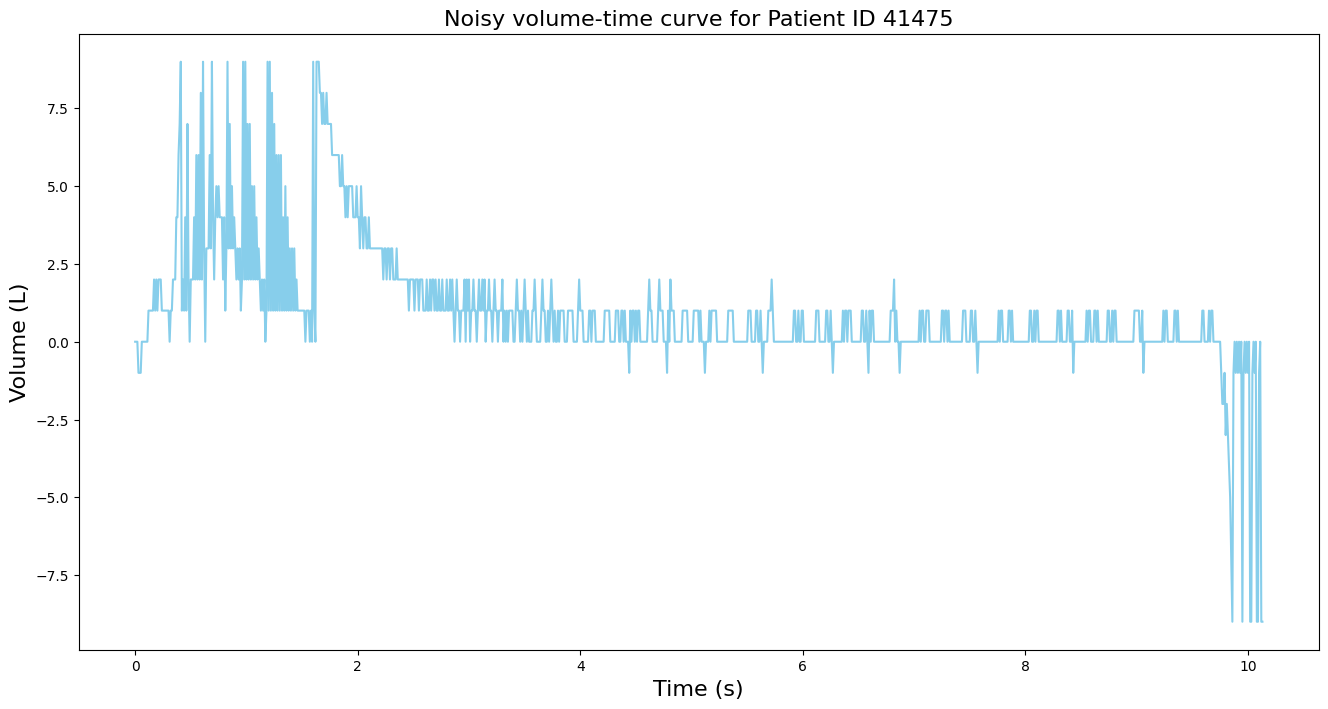

In [10]:
# Plotting the sequences with and without filtering them

sequence1 = str_tolist(df_clean["SPXRAW"].iloc[0])
time1 = create_time_flow([sequence1], period = T)

plt.figure(figsize = (16,8))
plt.plot(time1[0][0], sequence1, label='Volume', color='skyblue')
plt.title('Noisy volume-time curve for Patient ID 41475', fontsize = 16)
plt.xlabel('Time (s)', fontsize = 16)
plt.ylabel('Volume (L)', fontsize = 16)

In [11]:
# All the datatypes that are annotated as object in the data types inspection are strings
# The most relevant column in the dataset that will be used is SPXRAW, 
# which contains the recordings of the spirometry curve

def format_spirometry_curves(df, window_size): 
    '''This function aims to select and store in a list 
    the most promising sequences as a function of the relevant features.'''
    valid_sequences = []
    patient_ids = []
    for i in range(df.shape[0]):
        if (df.iloc[i]["SPAPLAT"] == "Y") and (df.iloc[i]["SPAPOS"] == "Standing")and (df.iloc[i]["SPATTYPE"] == "Pre") and (df.iloc[i]["SPAACC"] == "Y") and ((df.iloc[i]["SPAQEFF"] == "A") or (df.iloc[i]["SPAQEFF"] == "B")):
            raw_list = np.array(str_tolist(df.iloc[i]["SPXRAW"])*int(df.iloc[i]["SPAFACT"]))
            patient_ids.append(df.iloc[i]["SEQN"])
            smooth_list = np.convolve(raw_list, np.ones(window_size)/(window_size), mode = "valid")
            valid_sequences.append(smooth_list)
    return valid_sequences, patient_ids

sequences1, patients1 = format_spirometry_curves(df_clean, window_size=10)
# sequences2, patients2 = format_spirometry_curves(df2, window_size=20)
# sequences3, patients3 = format_spirometry_curves(df3, window_size=20)

def main():
    print("Number of valid sequences in df1:", len(sequences1), "compared to", df.shape[0], "total rows.")
    # print("Number of valid sequences in df2:", len(sequences2), "compared to", df2.shape[0], "total rows.")
    # print("Number of valid sequences in df3:", len(sequences3), "compared to", df3.shape[0], "total rows.")


if __name__ == "__main__":
    main()
    

Number of valid sequences in df1: 70234 compared to 108939 total rows.


In [ ]:
df_clean.head()

In [58]:
# Merging together all the valid sequences 
final_sequences = sequences1
final_patients = patients1

# It is important to get rid of the extermely short sequences, basically the ones showing a number of points lower than 600, which is indicated
# as the minimum number of points to obtain a sufficient expiratory cycle, measured at minimum 6 seconds (1 timestep is 10 ms)

short_seqs = [i for i, sequence in enumerate(final_sequences) if sequence.shape < (600,)]

percent_samples_lost = np.round((len(short_seqs)/len(final_sequences))*100,2)
print("The percentage of samples lost is about {int}".format(int = percent_samples_lost))

# Remove the short sequences from the total sequences list:
final_sequences = [value for i,value in enumerate(final_sequences) if i not in short_seqs]
final_patients = [value for i,value in enumerate(final_patients) if i not in short_seqs]

The percentage of samples lost is about 3.69


In [59]:
# Building a dictionary with the recordings and the patients id together:
def create_paralel_dict(list1, list2):
    dictionary = {}
    if len(list1) == len(list2):
        for i in range(len(list1)):
            if list1[i] in dictionary.keys():
                dictionary[list1[i]].append(list2[i])
            else:
                dictionary[list1[i]] = [list2[i]]
    else: 
        raise ValueError("The length of the lists doesn't match.")
    return dictionary

paralel_dict = create_paralel_dict(final_patients, final_sequences)
paralel_dict_peaks = create_paralel_dict(final_patients, peak_sequences)

In [60]:
import random

# Data spliting for avoiding leaking of patients into training or test
def data_spliting_patients(dict_par, test_size = 0.2, random_state = None):
    np.random.seed(random_state) 
    
    # getting the total number of keys
    list_keys = list(dict_par.keys())
    n_keys = len(list_keys)

    # Permutation of all the keys
    indices = np.random.permutation(n_keys)
    
    split_point = int(n_keys * (1 - test_size))
    train_idx, test_idx = indices[:split_point], indices[split_point:]

    train_keys = [list_keys[i] for i in train_idx]
    test_keys = [list_keys[i] for i in test_idx]

    training_data = [element for key in train_keys for element in dict_par[key]]
    test_data = [element for key in test_keys for element in dict_par[key]]

    return training_data, test_data


split = data_spliting_patients(paralel_dict, test_size = 0.2, random_state = 42)
# split_peaks = data_spliting_patients(paralel_dict_peaks, test_size = 0.2, random_state = 42)

In [61]:
final_sequences = split[0]+split[1]
# final_sequences_peaks = split_peaks[0]+split_peaks[1]

print(len(split[0]), len(split[1]))

54127 13512


In [53]:
len(final_sequences)

67639

In [72]:
# Trying to get the peaks and the main part of the curves 
from scipy.signal import find_peaks

def main_curves(sequences, left_window, right_window):
    '''Function that takes the raw spirometry sequences and 
    returns the main curve surrounding the highest peak.'''
    previous_peaks = None
    previous_value = None
    peak_seqs = []
    for i,value in enumerate(sequences):
        # print(value) 
        peaks, _ = find_peaks(value, height = 2, distance = 5)
        if len(peaks) == 0:
            peaks = previous_peaks 
            value = previous_value
        else:
            previous_peaks = peaks
            previous_value = value
            
        main_peak_idx = peaks[np.argmax(value[peaks])]
        left_start = max(0, main_peak_idx-left_window)
        right_end = min(len(value), main_peak_idx + right_window)
        left_segment = value[left_start:main_peak_idx]
        right_segment = value[main_peak_idx: right_end]

        if len(left_segment) == 0 or len(right_segment) == 0:
            print("Error")
            continue
    
        first_val = np.argmin(left_segment)
        last_val = np.argmin(right_segment) 
        peak_seqs.append(value[(left_start+first_val):(main_peak_idx+last_val)])            
    return peak_seqs
        


peak_sequences = main_curves(final_sequences, left_window = 80, right_window = 120)

In [77]:
split_peaks_train = peak_sequences[:len(split[0])]
split_peaks_test = peak_sequences[len(split[0]):]
final_sequences_peaks = split_peaks_train+ split_peaks_test

In [19]:
# Taking the indexes from the sequences that fail in providing clear peaks and removing them in the patients lists

# # Creating the set with the conflict indexes
# set_indexes = {8793, 13403, 30153, 30583, 67605}

# # Removing from the current list the indexes
# final_patients_peaks = [value for i, value in enumerate(final_patients) if i not in set_indexes]

# Checking the length of final patients and the final patients for the peaks
print(len(final_patients), len(peak_sequences))

67639 67639


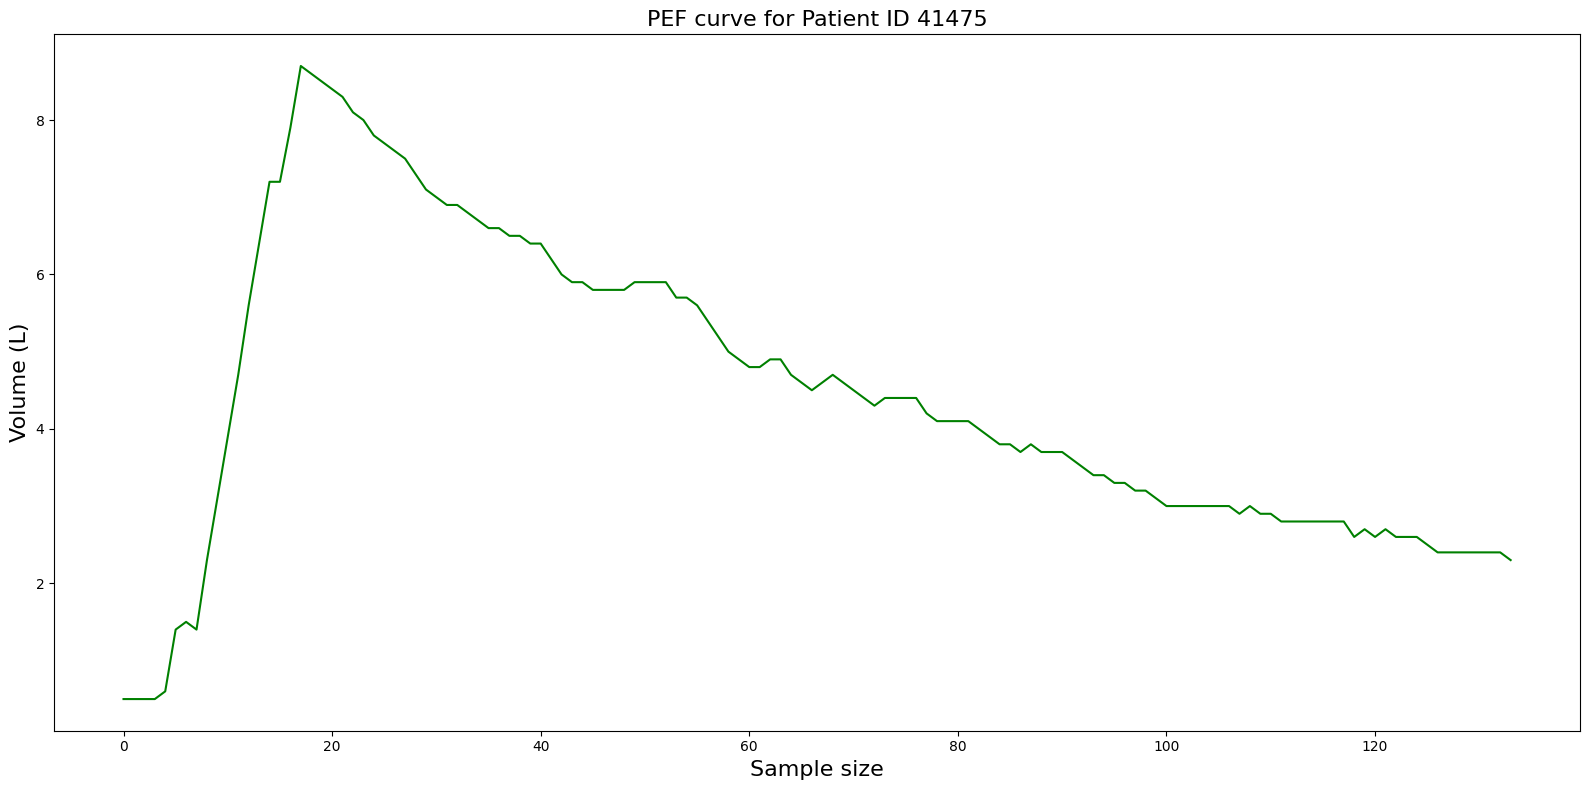

In [69]:
# Ploting the peaks

plt.figure(figsize=(16,8))

plt.plot(np.arange(len(peak_sequences[6])), peak_sequences[6], color = "green")
plt.title('PEF curve for Patient ID 41475', fontsize = 16)
plt.xlabel('Sample size', fontsize = 16)
plt.ylabel('Volume (L)', fontsize = 16)
plt.tight_layout()
plt.show()

In [74]:
time_sequences, flow_sequences = create_time_flow(final_sequences, period = T)

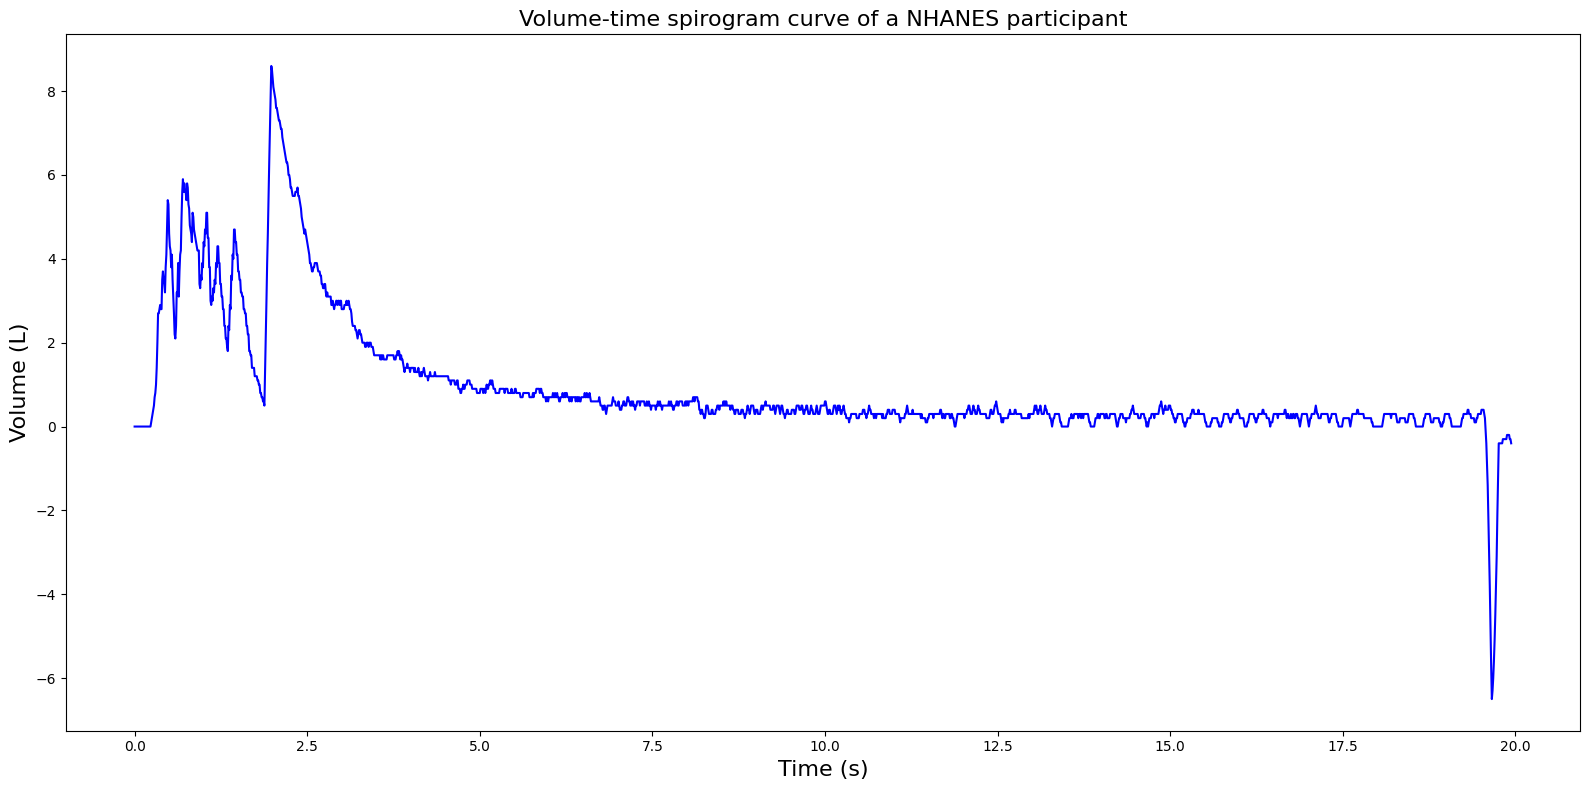

In [250]:
plt.figure(figsize=(16, 8))

# plt.subplot(211)
plt.plot(time_sequences[1], final_sequences[1], label='Volume', color='blue')
plt.title('Volume-time spirogram curve of a NHANES participant', fontsize = 16)
plt.xlabel('Time (s)', fontsize = 16)
plt.ylabel('Volume (L)', fontsize = 16)

# plt.subplot(212)
# plt.plot(time_sequences[6], final_sequences[6], label='Volume', color='blue')
# plt.title('Flow vs Volume for Patient 2')
# plt.xlabel('Time (s)')
# plt.ylabel('Volume (L)')

plt.tight_layout()
plt.show()

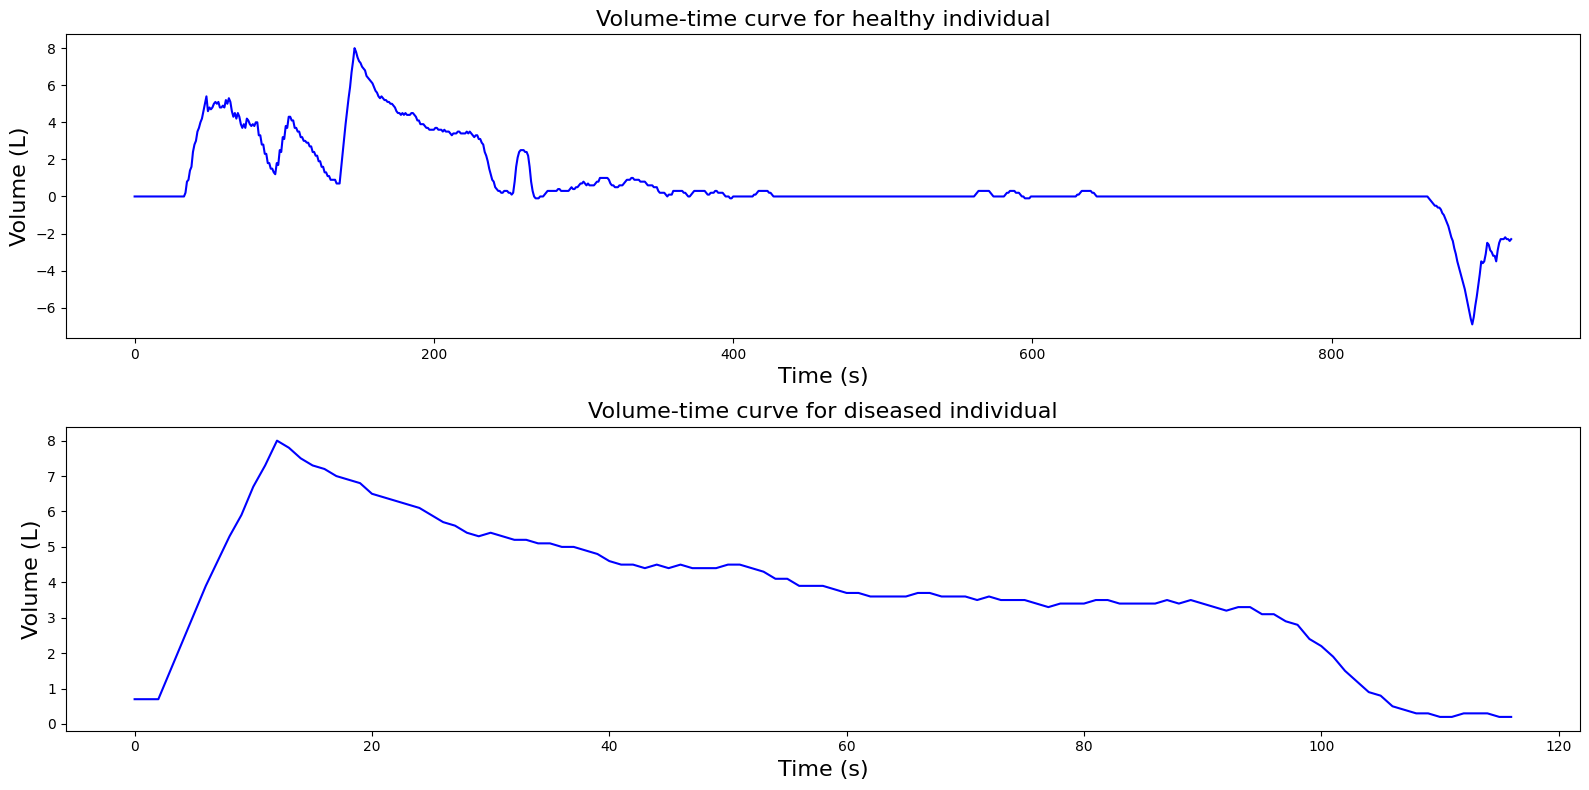

In [76]:
plt.figure(figsize=(16, 8))

plt.subplot(211)
plt.plot(np.arange(split[1][200].shape[0]), split[1][200], label='Volume', color='blue')
plt.title('Volume-time curve for healthy individual', fontsize = 16)
plt.xlabel('Time (s)', fontsize = 16)
plt.ylabel('Volume (L)', fontsize = 16)

plt.subplot(212)
plt.plot(np.arange(split_peaks_test[200].shape[0]), split_peaks_test[200], label='Volume', color='blue')
plt.title('Volume-time curve for diseased individual', fontsize = 16)
plt.xlabel('Time (s)', fontsize = 16)
plt.ylabel('Volume (L)', fontsize = 16)

plt.tight_layout()
plt.show()

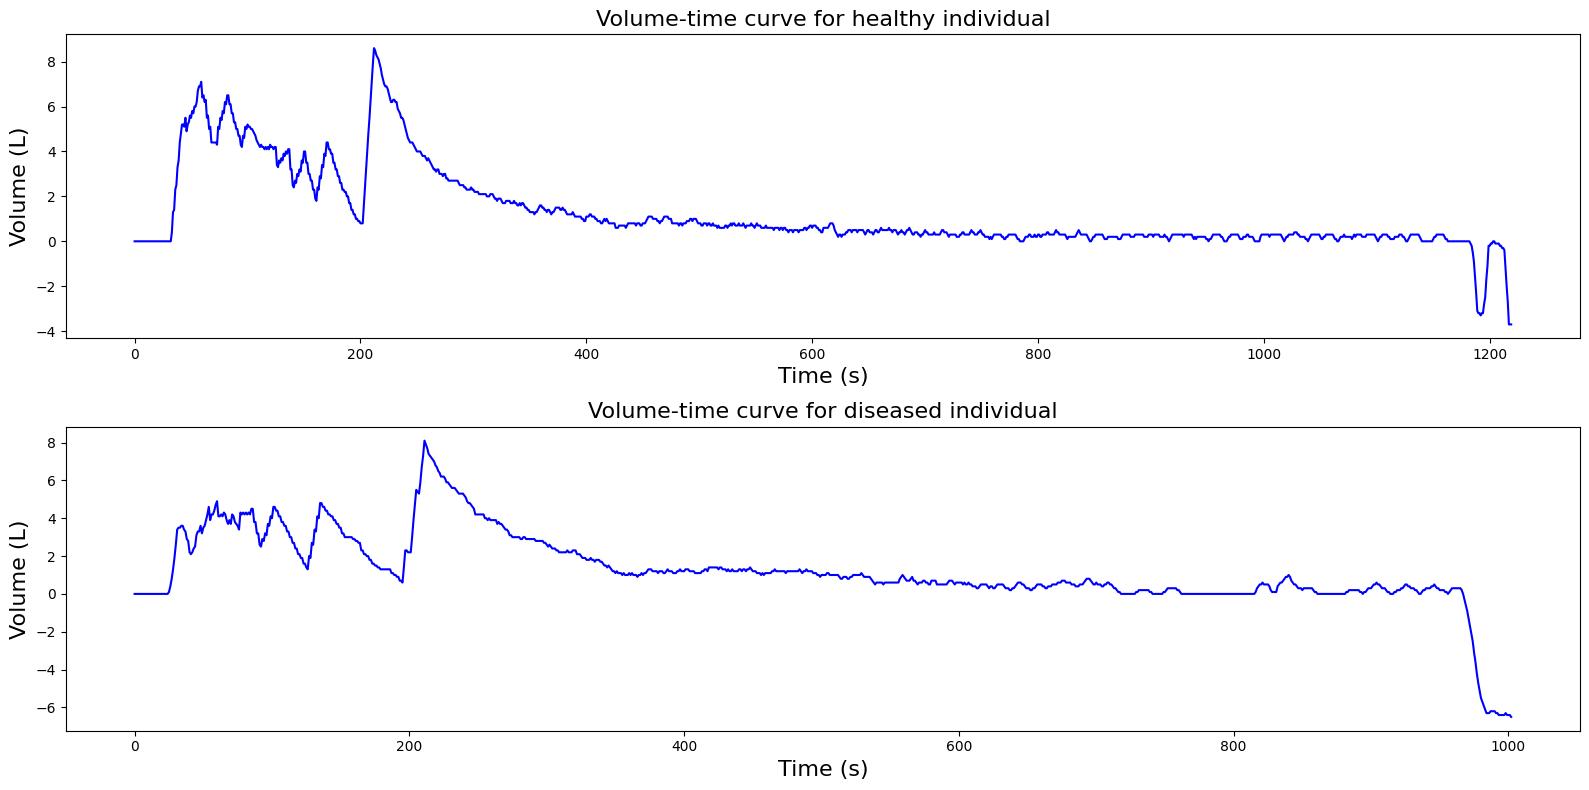

In [235]:
plt.figure(figsize=(16, 8))

[1420, 1765]

plt.subplot(211)
plt.plot(np.arange(split[1][1420].shape[0]), split[1][1420], label='Volume', color='blue')
plt.title('Volume-time curve for healthy individual', fontsize = 16)
plt.xlabel('Time (s)', fontsize = 16)
plt.ylabel('Volume (L)', fontsize = 16)

plt.subplot(212)
plt.plot(np.arange(split[1][1765].shape[0]), split[1][1765], label='Volume', color='blue')
plt.title('Volume-time curve for diseased individual', fontsize = 16)
plt.xlabel('Time (s)', fontsize = 16)
plt.ylabel('Volume (L)', fontsize = 16)

plt.tight_layout()
plt.show()

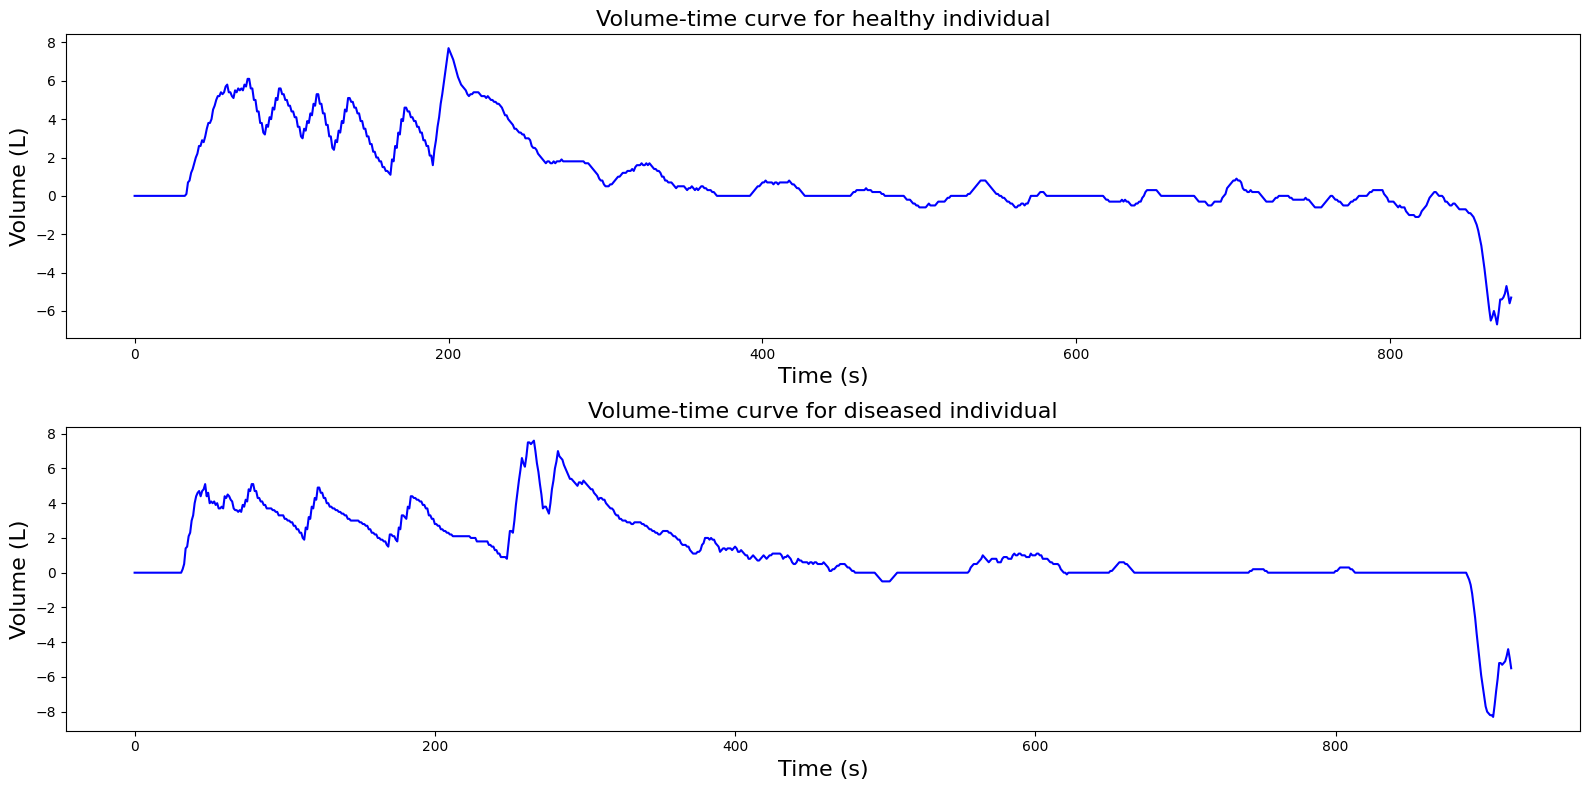

In [236]:
plt.figure(figsize=(16, 8))

plt.subplot(211)
plt.plot(np.arange(split[1][10].shape[0]), split[1][10], label='Volume', color='blue')
plt.title('Volume-time curve for healthy individual', fontsize = 16)
plt.xlabel('Time (s)', fontsize = 16)
plt.ylabel('Volume (L)', fontsize = 16)

plt.subplot(212)
plt.plot(np.arange(split[1][80].shape[0]), split[1][80], label='Volume', color='blue')
plt.title('Volume-time curve for diseased individual', fontsize = 16)
plt.xlabel('Time (s)', fontsize = 16)
plt.ylabel('Volume (L)', fontsize = 16)

plt.tight_layout()
# plt.show()

In [79]:
# For some models, all the sequences must have the same length, so padding is important and necessary
from tensorflow.keras.utils import pad_sequences

# Padding the full sequences
padded_sequences = pad_sequences(final_sequences, padding = "post", dtype = "float32", truncating = "post")
padded_sequences = [value[0:len(padded_sequences[0])-1] for value in padded_sequences]

# Padding the peak sequences
padded_sequences_peaks = pad_sequences(final_sequences_peaks, maxlen = 200, padding = "post", dtype = "float32", truncating = "post")
# padded_sequences = [value[0:len(padded_sequences[0])-1] for value in padded_sequences]

# Data spliting for the padded sequences
train_data, test_data = padded_sequences[0:len(split[0])], padded_sequences[len(split[0]):]
print(len(train_data) , len(test_data))

# Data spliting for the padded sequences
train_data_peaks, test_data_peaks = padded_sequences_peaks[0:len(split_peaks_train)], padded_sequences_peaks[len(split_peaks_train):]
print(len(train_data_peaks) , len(test_data_peaks))

54127 13512
54127 13512


In [39]:
padded_sequences_peaks[1].shape

(200,)

#### Trying clustering algorithms on raw data

##### Kmeans

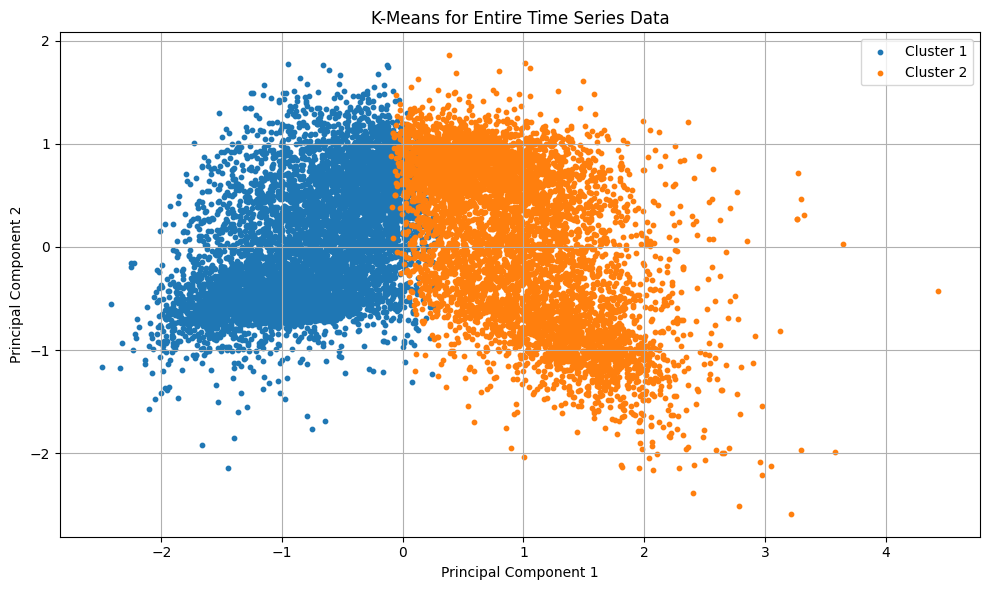

In [206]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Reshaping the data for the compressed representation
train_array = np.array(train_data)
test_array = np.array(test_data)

scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_array)
test_scaled = scaler.transform(test_array)   # ✅ use transform, not fit_transform

kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(train_scaled)
test_labels = kmeans.predict(test_scaled)

# Apply PCA for visualization
pca = PCA(n_components=2)
X_2D = pca.fit_transform(test_scaled)

plt.figure(figsize=(10, 6))

# Plot each cluster with its own color and label
for cluster_id in np.unique(test_labels):
    cluster_points = X_2D[test_labels == cluster_id]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], 
                s=10, label=f"Cluster {cluster_id+1}")

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("K-Means for Entire Time Series Data")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [149]:
from sklearn.metrics import silhouette_score

score = silhouette_score(test_scaled, test_labels, metric = "euclidean")
print("Silhouette Score: %.3f" %score)

Silhouette Score: 0.110


##### DBSCAN

If this is run, VS explotes

/tmp/ipykernel_763884/1151287824.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


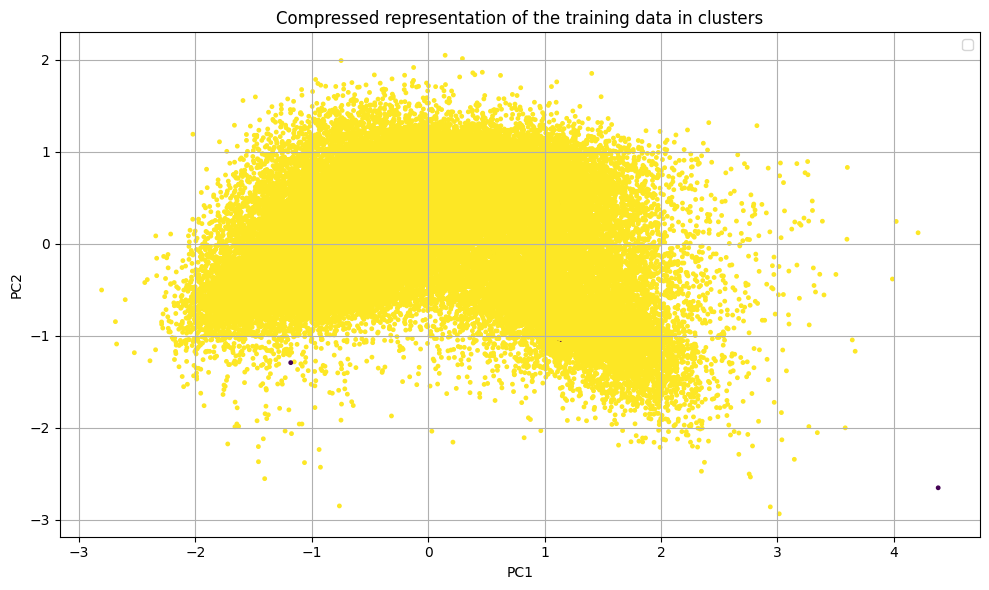

In [150]:
from sklearn.cluster import DBSCAN

scaler = MinMaxScaler()
train_subset = scaler.fit_transform(train_subset)

clustering = DBSCAN(eps = 5, min_samples = 10000)
clustering.fit(train_subset)
training_labels = clustering.labels_

pca = PCA(n_components = 2)
X_2D = pca.fit_transform(train_subset)

plt.figure(figsize = (10,6))
plt.scatter(X_2D[:,0], X_2D[:,1], c = training_labels, s = 6)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Compressed representation of the training data in clusters")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


##### Agglomerative clustering

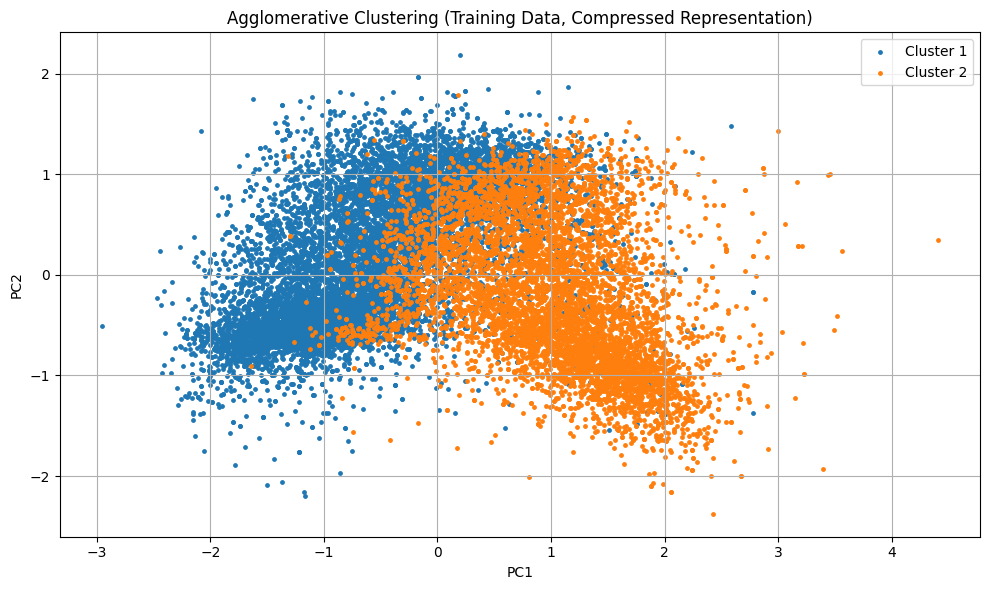

In [164]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.utils import resample
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Resample data
train_subset = resample(train_array, n_samples=20000, random_state=42)

# Scale data
scaler = MinMaxScaler()
train_subset = scaler.fit_transform(train_subset)

# Agglomerative clustering
clustering = AgglomerativeClustering(n_clusters=2, metric='euclidean', linkage='ward')
clustering.fit(train_subset)
train_labels = clustering.labels_

# PCA for visualization
pca = PCA(n_components=2)
X_2D = pca.fit_transform(train_subset)

# Plot clusters with colors + legend
plt.figure(figsize=(10, 6))
for cluster_id in np.unique(train_labels):
    cluster_points = X_2D[train_labels == cluster_id]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1],
                s=6, label=f"Cluster {cluster_id+1}")

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Agglomerative Clustering (Training Data, Compressed Representation)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [156]:
from sklearn.metrics import silhouette_score

score = silhouette_score(train_subset, train_labels, metric = "euclidean")
print("Silhouette Score: %.3f" %score)

Silhouette Score: 0.097


#### Trying clustering algorithms on peaks data

##### K Means

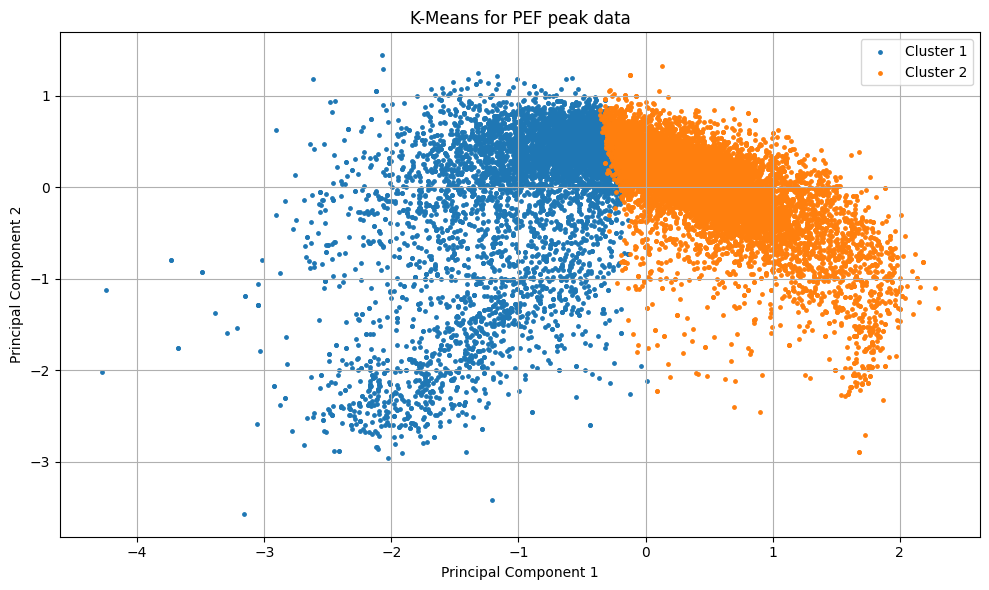

In [207]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.utils import resample
import matplotlib.pyplot as plt
import numpy as np

# Reshaping the data for the compressed representation
train_array_peaks = np.array(train_data_peaks)

# Resample
train_subset = resample(train_array_peaks, n_samples=20000, random_state=42)

# Scale
scaler = MinMaxScaler()
train_subset = scaler.fit_transform(train_subset)

# KMeans clustering
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(train_subset)
train_labels = kmeans.labels_
centroids = kmeans.cluster_centers_

# PCA projection
pca = PCA(n_components=2)
X_2D = pca.fit_transform(train_subset)

# Plot clusters with colors + legend
plt.figure(figsize=(10, 6))
for cluster_id in np.unique(train_labels):
    cluster_points = X_2D[train_labels == cluster_id]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1],
                s=6, label=f"Cluster {cluster_id+1}")

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("K-Means for PEF peak data")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [208]:
from sklearn.metrics import silhouette_score

score = silhouette_score(train_subset, train_labels, metric = "euclidean")
print("Silhouette Score: %.3f" %score)

Silhouette Score: 0.326


##### DBSCAN

In [ ]:
from sklearn.cluster import DBSCAN

scaler = MinMaxScaler()
train_subset = scaler.fit_transform(train_subset)

clustering = DBSCAN(eps = 3, min_samples = 30000)
clustering.fit(train_subset)
training_labels = clustering.labels_

pca = PCA(n_components = 2)
X_2D = pca.fit_transform(train_subset)

plt.figure(figsize = (10,6))
plt.scatter(X_2D[:,0], X_2D[:,1], c = training_labels, s = 6)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Compressed representation of the training data in clusters")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

#### Agglomerative clustering

/tmp/ipykernel_763884/2532457631.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


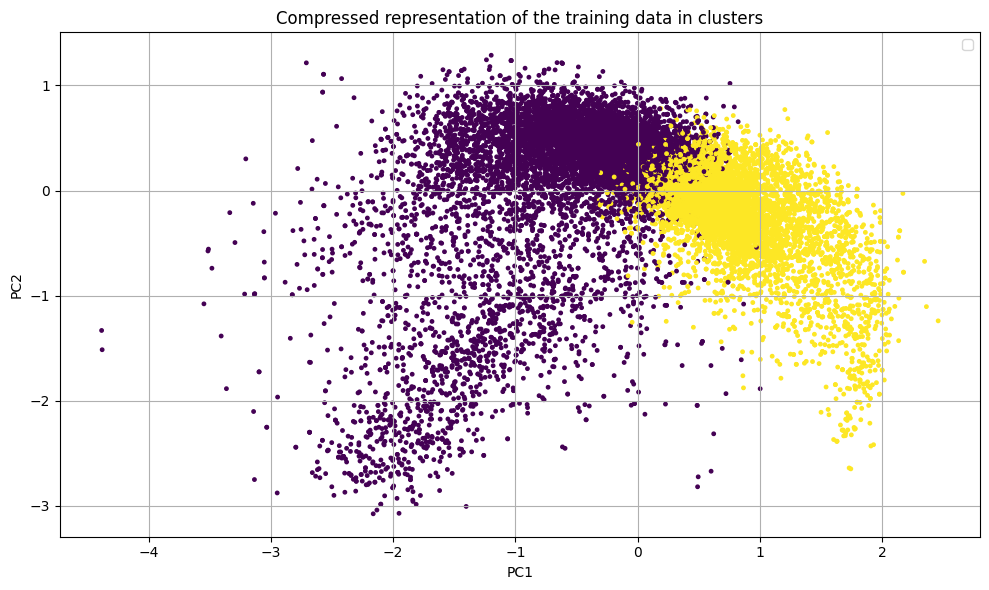

In [159]:
from sklearn.cluster import AgglomerativeClustering

scaler = MinMaxScaler()
train_subset = scaler.fit_transform(train_subset)

clustering = AgglomerativeClustering(n_clusters = 2, metric = 'euclidean', linkage = 'ward')
clustering.fit(train_subset)
train_labels = clustering.labels_

pca = PCA(n_components = 2)
X_2D = pca.fit_transform(train_subset)

plt.figure(figsize = (10,6))
plt.scatter(X_2D[:,0], X_2D[:,1], c = train_labels, s = 6)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Compressed representation of the training data in clusters")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [160]:
from sklearn.metrics import silhouette_score

score = silhouette_score(train_subset, train_labels, metric = "euclidean")
print("Silhouette Score: %.3f" %score)

Silhouette Score: 0.224


### 1st model: Autoencoder + Clustering on raw data

In [ ]:
# from tensorflow.keras import layers, models

# input_shape = (len(train_data[0]), 1)

# input_layer = layers.Input(shape=input_shape)
# encoded = layers.Conv1D(64, 3, activation="relu", padding="same")(input_layer)
# encoded = layers.MaxPooling1D(2, padding="valid")(encoded)
# encoded = layers.Conv1D(32, 3, activation="relu", padding="same")(encoded)
# encoded = layers.MaxPooling1D(2, padding="valid")(encoded)
# encoded = layers.Conv1D(16, 3, activation="relu", padding="same")(encoded)
# encoded = layers.MaxPooling1D(2, padding="valid")(encoded)
# encoded = layers.Conv1D(1, 3, activation="relu", padding="same")(encoded)

# decoded = layers.Conv1D(16, 3, activation="relu", padding="same")(encoded)
# decoded = layers.UpSampling1D(2)(decoded)
# decoded = layers.Conv1D(32, 3, activation="relu", padding="same")(decoded)
# decoded = layers.UpSampling1D(2)(decoded)
# decoded = layers.Conv1D(64, 3, activation="relu", padding="same")(decoded)
# decoded = layers.UpSampling1D(2)(decoded)
# decoded = layers.ZeroPadding1D((2, 2))(decoded)
# output_layer = layers.Conv1D(1, 3, activation="sigmoid", padding="same")(decoded)

# autoencoder = models.Model(inputs=input_layer, outputs=output_layer)
# autoencoder.compile(optimizer="adam", loss="mse")
# autoencoder.summary()

In [130]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

train_data = np.array(train_data)  
test_data = np.array(test_data)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(train_data)
X_test_scaled = scaler.transform(test_data)

X_train_scaled = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_test_scaled = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

X_train_reservoir = [record.squeeze() for record in X_train_scaled]
X_test_reservoir = [record.squeeze() for record in X_test_scaled]

In [129]:
X_train_scaled.shape

(54127, 2310, 1)

In [41]:
import numpy as np
from tensorflow.keras import layers, models, optimizers
import keras_tuner as kt
from sklearn.model_selection import train_test_split

# -------------------------------------------------
# 1. Prepare your data (example dummy data)
# Replace this with your real time series data
# -------------------------------------------------
X_train = X_train_scaled
X_test = X_test_scaled

input_shape = (X_train.shape[1], X_train.shape[2])

# -------------------------------------------------
# 2. Build model function for KerasTuner
# -------------------------------------------------
def build_model(hp):
    input_layer = layers.Input(shape=input_shape)
    
    # Encoder
    x = layers.Conv1D(
        filters=hp.Choice('filters1', [32, 64, 128]),
        kernel_size=hp.Choice('kernel1', [3, 5, 7]),
        activation="relu", padding="same")(input_layer)
    x = layers.MaxPooling1D(pool_size=2, padding = "same")(x)
    
    x = layers.Conv1D(
        filters=hp.Choice('filters2', [16, 32, 64]),
        kernel_size=hp.Choice('kernel2', [3, 5, 7]),
        activation="relu", padding="same")(x)
    x = layers.MaxPooling1D(pool_size=2, padding = "same")(x)
    
    x = layers.Conv1D(
        filters=hp.Choice('filters3', [8, 16, 32]),
        kernel_size=hp.Choice('kernel3', [3, 5, 7]),
        activation="relu", padding="same")(x)
    x = layers.MaxPooling1D(pool_size=2, padding = "same")(x)
    
    encoded = layers.Conv1D(
        filters=hp.Choice('filters4', [1, 4, 8]),
        kernel_size=hp.Choice('kernel4', [3, 5, 7]),
        activation="relu", padding="same", 
        name = "encoded_layer")(x)

    encoded_single = layers.Conv1D(
        filters=1,
        kernel_size=1,
        activation="linear",
        padding="same",
        name="encoded_single")(encoded)
    
    # Decoder
    x = layers.Conv1D(
        filters=hp.Choice('filters5', [8, 16, 32]),
        kernel_size=hp.Choice('kernel5', [3, 5, 7]),
        activation="relu", padding="same")(encoded_single)
    x = layers.UpSampling1D(2)(x)
    
    x = layers.Conv1D(
        filters=hp.Choice('filters6', [16, 32, 64]),
        kernel_size=hp.Choice('kernel6', [3, 5, 7]),
        activation="relu", padding="same")(x)
    x = layers.UpSampling1D(2)(x)
    
    x = layers.Conv1D(
        filters=hp.Choice('filters7', [32, 64, 128]),
        kernel_size=hp.Choice('kernel7', [3, 5, 7]),
        activation="relu", padding="same")(x)
    x = layers.UpSampling1D(2)(x)
    x = layers.Cropping1D(cropping=(0, 2))(x)
    # x = layers.ZeroPadding1D((1, 1))(x)
    
    output_layer = layers.Conv1D(1, 3, activation="sigmoid", padding="same")(x)
    
    model = models.Model(inputs=input_layer, outputs=output_layer)
    model.compile(
        optimizer= optimizers.Adam(
            hp.Choice("learning_rate", [1e-2, 1e-3, 1e-4])),
        loss="mse"
    )
    
    return model

# -------------------------------------------------
# 3. Hyperparameter tuning
# -------------------------------------------------
tuner = kt.RandomSearch(
    build_model,
    objective="val_loss",
    max_trials=5,
    executions_per_trial=1,
    directory="tuner_results5",
    project_name="spirometry"
)

tuner.search(X_train, X_train, epochs=10, batch_size=32, validation_split=0.2)

# -------------------------------------------------
# 4. Get best model
# -------------------------------------------------
best_model = tuner.get_best_models(num_models=1)[0]
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters:", best_hp.values)

# -------------------------------------------------
# 5. Train the best model with early stopping
# -------------------------------------------------
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

history = best_model.fit(
    X_train, X_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[es]
)

# -------------------------------------------------
# 6. Evaluate on test data
# -------------------------------------------------
test_loss = best_model.evaluate(X_test, X_test)
print("Test reconstruction loss:", test_loss)

# -------------------------------------------------
# 7. Predict reconstructed signals
# -------------------------------------------------
reconstructed = best_model.predict(X_test)

Reloading Tuner from tuner_results5/spirometry/tuner0.json


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Best hyperparameters: {'filters1': 128, 'kernel1': 3, 'filters2': 16, 'kernel2': 3, 'filters3': 8, 'kernel3': 3, 'filters4': 8, 'kernel4': 3, 'filters5': 32, 'kernel5': 3, 'filters6': 64, 'kernel6': 5, 'filters7': 32, 'kernel7': 5, 'learning_rate': 0.01}
Epoch 1/50


I0000 00:00:1755774382.465952  877101 service.cc:152] XLA service 0x7ff008002650 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1755774382.465980  877101 service.cc:160]   StreamExecutor device (0): NVIDIA A100 80GB PCIe, Compute Capability 8.0
2025-08-21 11:06:22.514110: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1755774382.803201  877101 cuda_dnn.cc:529] Loaded cuDNN version 90501
Could not load symbol cuFuncGetName. Error: /usr/lib/x86_64-linux-gnu/libcuda.so.1: undefined symbol: cuFuncGetName


  30/1354 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0113        

I0000 00:00:1755774385.172678  877101 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1354/1354 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - loss: 3.4782e-04 - val_loss: 1.6583e-04
Epoch 2/50
1354/1354 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 2.1990e-04 - val_loss: 1.8731e-04
Epoch 3/50
1354/1354 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 1.7403e-04 - val_loss: 1.5210e-04
Epoch 4/50
1354/1354 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 1.5476e-04 - val_loss: 1.3787e-04
Epoch 5/50
1354/1354 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.0095 - val_loss: 0.0134
Epoch 6/50
1354/1354 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.0089 - val_loss: 0.0101
Epoch 7/50
1354/1354 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.0086 - val_loss: 0.0083
Epoch 8/50
1354/1354 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.0096 - val_loss: 0.0107
Epoch 9/50
1354/1354 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.0157 - val_loss: 0.0124
423/423 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.3980e-04 
Test reconstruction loss: 0.00013980286894366145
423/423 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step    


In [234]:

# history = autoencoder.fit(
#     X_train_scaled,
#     X_train_scaled,
#     epochs=10,
#     batch_size=64,
#     shuffle=True,
#     validation_split=0.1
# )

In [44]:
from tensorflow.keras import Model

encoder = Model(inputs = best_model.input, outputs = best_model.get_layer("encoded_single").output)

X_train_scaled = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_test_scaled = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

compressed_train_data = encoder.predict(X_train_scaled)
compressed_test_data = encoder.predict(X_test_scaled)

compressed_train_data = compressed_train_data.reshape(compressed_train_data.shape[0], compressed_train_data.shape[1])
compressed_test_data = compressed_test_data.reshape(compressed_test_data.shape[0], compressed_test_data.shape[1])
print(compressed_train_data.shape, compressed_test_data.shape)

1692/1692 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step  
423/423 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step  
(54127, 289) (13512, 289)


In [ ]:
compressed_train_data[0]

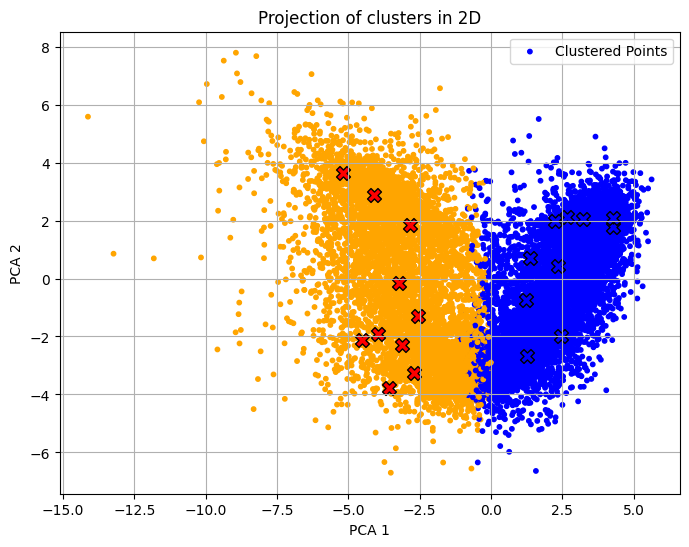

In [175]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 2)
kmeans.fit(compressed_train_data)
compressed_test_labels = kmeans.predict(compressed_test_data)

X_2d = PCA(n_components=2).fit_transform(compressed_test_data)

healthy_indices = [10,902,12,13,101,15,301,36,25,38]
disease_indices = [80,81,82,86,87,88,89,19,182,2003] 

custom_colors = ['blue', 'orange']
cluster_colors = [custom_colors[label] for label in compressed_test_labels]

plt.figure(figsize=(8, 6))
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=cluster_colors, s=10, label='Clustered Points')

highlighted_points = X_2d[healthy_indices]
plt.scatter(highlighted_points[:, 0], highlighted_points[:, 1], 
            color='blue', edgecolor='black', s=100, marker='X')

highlighted_points = X_2d[disease_indices]
plt.scatter(highlighted_points[:, 0], highlighted_points[:, 1], 
            color='red', edgecolor='black', s=100, marker='X')

plt.title("Projection of clusters in 2D")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.legend()
plt.show()

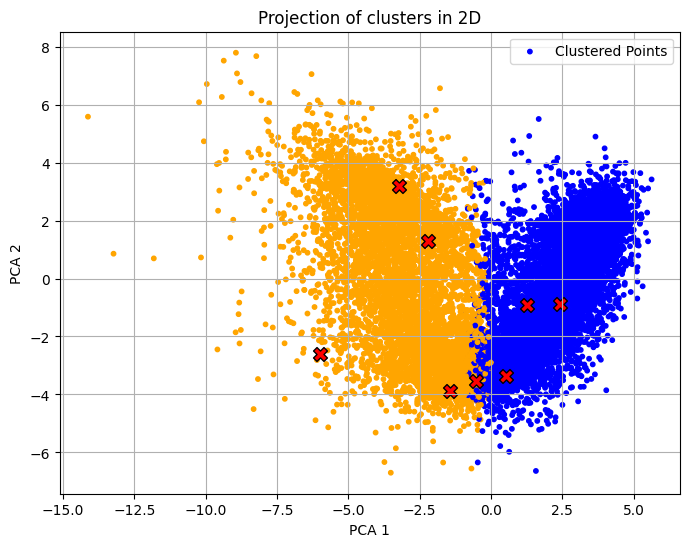

In [97]:
# Computing the Silhouette score

from sklearn.metrics import silhouette_score

score = silhouette_score(compressed_test_data, compressed_test_labels, metric = "euclidean")
print("Silhouette Score: %.3f" %score)

Silhouette Score: 0.159


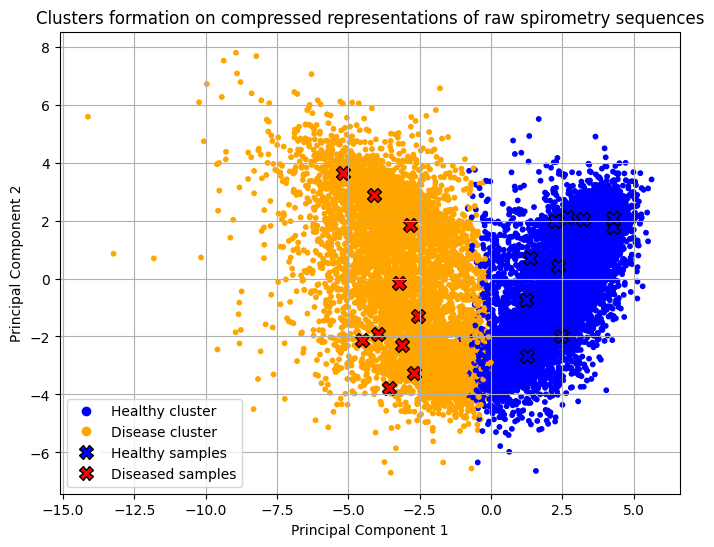

In [90]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Colors for clusters
custom_colors = ['blue', 'orange']
cluster_colors = [custom_colors[label] for label in compressed_test_labels]

plt.figure(figsize=(8, 6))

# Scatter for clusters
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=cluster_colors, s=10)

# Scatter for healthy points
highlighted_healthy = X_2d[healthy_indices]
plt.scatter(highlighted_healthy[:, 0], highlighted_healthy[:, 1], 
            color='blue', edgecolor='black', s=100, marker='X')

# Scatter for disease points
highlighted_disease = X_2d[disease_indices]
plt.scatter(highlighted_disease[:, 0], highlighted_disease[:, 1], 
            color='red', edgecolor='black', s=100, marker='X')

plt.title("Clusters formation on compressed representations of raw spirometry sequences")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)

# Custom legend
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Healthy cluster', markerfacecolor='blue', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='Disease cluster', markerfacecolor='orange', markersize=8),
    Line2D([0], [0], marker='X', color='w', label='Healthy samples', markerfacecolor='blue', markeredgecolor='black', markersize=10),
    Line2D([0], [0], marker='X', color='w', label='Diseased samples', markerfacecolor='red', markeredgecolor='black', markersize=10)
]

plt.legend(handles=legend_elements)
plt.show()


In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(211)
plt.plot(np.arange(1, 2301), train_data[10], label='Volume', color='blue')
plt.title('Volume vs Time for Patient 1')
plt.xlabel('Time (s)')
plt.ylabel('Volume (L)')

plt.subplot(212)
plt.plot(np.arange(1, 2301), train_data[11], label='Volume', color='blue')
plt.title('Flow vs Volume for Patient 2')
plt.xlabel('Time (s)')
plt.ylabel('Volume (L)')

plt.tight_layout()
plt.show()

- Patient 10 corresponds to the one whcih presents an abnormal behavior in the descent of the curve -> It can be argued that violet area is the one representing the disease. 

- Patient 11 corresponds to the one presenting the normal behavior, so the yellow area is the healthy area.

Next steps to perform on this model:

- Perform the Silouette Score to explore the separation between the clusters 
- Explore the centroids of the clusters
- Análisis de reconstruccionn del autoencoder
- Inspeccionar las activaciones del encoder

### 2nd Model: Reservoir computing + Clustering on raw data

In [131]:
import numpy as np
import reservoirpy as rpy
from reservoirpy.nodes import Reservoir

rpy.verbosity(0)
rpy.set_seed(42)

# Definir rangos de hiperparámetros
units_list = [50, 100, 150, 200, 250, 300]
lr_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
sr_list = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5]

n_trials = 20  # número de combinaciones aleatorias a probar
best_score = -np.inf
best_params = None

for _ in range(n_trials):
    # Selección aleatoria de hiperparámetros
    units = np.random.choice(units_list)
    lr = np.random.choice(lr_list)
    sr = np.random.choice(sr_list)
    
    reservoir = Reservoir(units=units, lr=lr, sr=sr)
    
    all_states = []
    for timeserie in X_train_reservoir:
        reservoir.reset()
        states = reservoir.run(timeserie)
        all_states.append(states)
    
    training_features = np.array(all_states)
    
    # Métrica: varianza promedio de los estados del reservoir
    neuron_variances = np.var(training_features, axis=(0,1))
    score = np.mean(neuron_variances)
    
    if score > best_score:
        best_score = score
        best_params = {"units": units, "lr": lr, "sr": sr}

print("Best hyperparameters:", best_params)
print("Best score (mean variance):", best_score)

Best hyperparameters: {'units': np.int64(200), 'lr': np.float64(1.0), 'sr': np.float64(1.0)}
Best score (mean variance): 0.03168402000767651


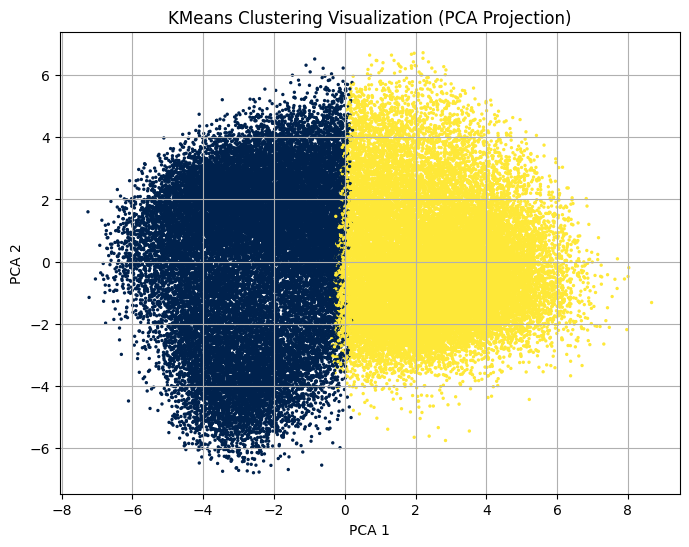

In [167]:
import reservoirpy as rpy
from reservoirpy.nodes import Reservoir

rpy.verbosity(0)
rpy.set_seed(42)

reservoir_def = Reservoir(units = 200, lr = 1, sr = 1)

all_states = []
for timeserie in train_data: 
    reservoir_def.reset()
    states = reservoir_def.run(timeserie)
    all_states.append(states)

training_features = np.array(all_states)

training_features = training_features.reshape(training_features.shape[0], -1)

n_cluster = 2
kmeans = KMeans(n_clusters = n_cluster, random_state = 12)
train_labels = kmeans.fit_predict(training_features)

X_2d = PCA(n_components=2).fit_transform(training_features)

plt.figure(figsize=(8,6))
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=train_labels, cmap='cividis', s=2)

plt.title("KMeans Clustering Visualization (PCA Projection)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.show()

In [156]:
training_features.shape

(54127, 200)

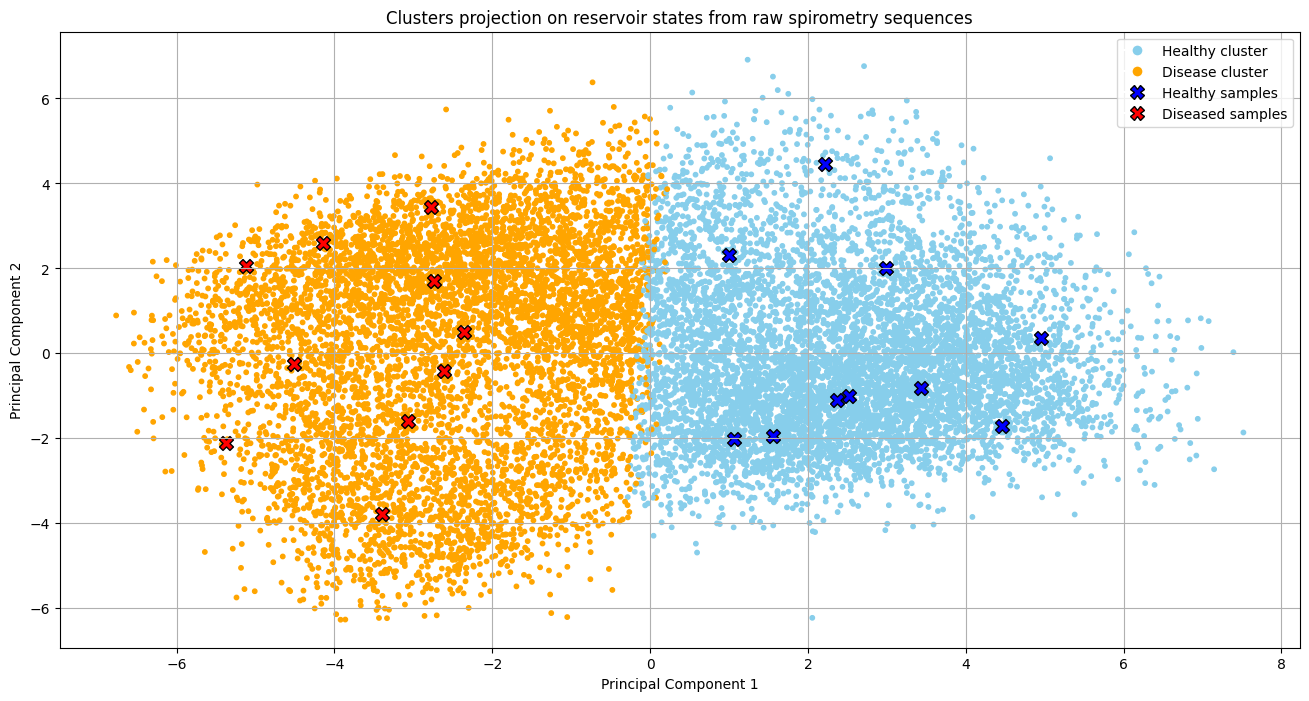

In [168]:
# Applying the reservoir to the test data

all_states_test = []
for timeserie in test_data: 
    reservoir_def.reset()
    states = reservoir_def.run(timeserie)
    all_states_test.append(states)

test_features = np.array(all_states_test)

test_features = test_features.reshape(test_features.shape[0], -1)
test_labels = kmeans.predict(test_features)

X_2d = PCA(n_components=2).fit_transform(test_features)

plt.figure(figsize=(16,8))

healthy_indices = [10,902,12,13,101,15,301,36,25,38]
disease_indices = [80,81,82,86,87,88,89,19,182,2003] 

custom_colors = ['orange', 'skyblue']
cluster_colors = [custom_colors[label] for label in test_labels]
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=cluster_colors, s=10)


highlighted_points = X_2d[healthy_indices]
plt.scatter(highlighted_points[:, 0], highlighted_points[:, 1], 
            color='blue', edgecolor='black', s=100, marker='X')

highlighted_points = X_2d[disease_indices]
plt.scatter(highlighted_points[:, 0], highlighted_points[:, 1], 
            color='red', edgecolor='black', s=100, marker='X')

plt.title("Clusters projection on reservoir states from raw spirometry sequences")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)

# Custom legend
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Healthy cluster', markerfacecolor='skyblue', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='Disease cluster', markerfacecolor='orange', markersize=8),
    Line2D([0], [0], marker='X', color='w', label='Healthy samples', markerfacecolor='blue', markeredgecolor='black', markersize=10),
    Line2D([0], [0], marker='X', color='w', label='Diseased samples', markerfacecolor='red', markeredgecolor='black', markersize=10)
]

plt.legend(handles=legend_elements)
plt.show()

In [153]:
test_features.shape

(13512, 200)

In [170]:
score = silhouette_score(test_features, test_labels, metric = "euclidean")
print("Silhouette Score: %.3f" %score)

Silhouette Score: 0.073


### 3rd model:  Autoencoder + Clustering on peaks data

In [134]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

train_data_peaks = np.array(train_data_peaks)  
test_data_peaks = np.array(test_data_peaks)

scaler = MinMaxScaler()
X_train_scaled_peaks = scaler.fit_transform(train_data_peaks)
X_test_scaled_peaks = scaler.transform(test_data_peaks)

X_train_scaled_peaks = X_train_scaled_peaks.reshape(X_train_scaled_peaks.shape[0], X_train_scaled_peaks.shape[1], 1)
X_test_scaled_peaks = X_test_scaled_peaks.reshape(X_test_scaled_peaks.shape[0], X_test_scaled_peaks.shape[1], 1)

X_train_peaks_reservoir = [record.squeeze() for record in X_train_scaled_peaks]
X_test_peaks_reservoir = [record.squeeze() for record in X_test_scaled_peaks]

In [210]:
X_train_scaled_peaks.shape

(54127, 200, 1)

In [82]:
import numpy as np
from tensorflow.keras import layers, models, optimizers
import keras_tuner as kt
from sklearn.model_selection import train_test_split

# -------------------------------------------------
# 1. Prepare your data (example dummy data)
# Replace this with your real time series data
# -------------------------------------------------
X_train = X_train_scaled_peaks
X_test = X_train_scaled_peaks

input_shape = (X_train.shape[1], X_train.shape[2])

# -------------------------------------------------
# 2. Build model function for KerasTuner
# -------------------------------------------------
def build_model(hp):
    input_layer = layers.Input(shape=input_shape)
    
    # Encoder
    x = layers.Conv1D(
        filters=hp.Choice('filters1', [32, 64, 128]),
        kernel_size=hp.Choice('kernel1', [3, 5, 7]),
        activation="relu", padding="same")(input_layer)
    x = layers.MaxPooling1D(pool_size=2, padding = "same")(x)
    
    x = layers.Conv1D(
        filters=hp.Choice('filters2', [16, 32, 64]),
        kernel_size=hp.Choice('kernel2', [3, 5, 7]),
        activation="relu", padding="same")(x)
    x = layers.MaxPooling1D(pool_size=2, padding = "same")(x)
    
    x = layers.Conv1D(
        filters=hp.Choice('filters3', [8, 16, 32]),
        kernel_size=hp.Choice('kernel3', [3, 5, 7]),
        activation="relu", padding="same")(x)
    x = layers.MaxPooling1D(pool_size=2, padding = "same")(x)
    
    encoded = layers.Conv1D(
        filters=hp.Choice('filters4', [1, 4, 8]),
        kernel_size=hp.Choice('kernel4', [3, 5, 7]),
        activation="relu", padding="same", 
        name = "encoded_layer")(x)

    encoded_single = layers.Conv1D(
        filters=1,
        kernel_size=1,
        activation="linear",
        padding="same",
        name="encoded_single")(encoded)
    
    # Decoder
    x = layers.Conv1D(
        filters=hp.Choice('filters5', [8, 16, 32]),
        kernel_size=hp.Choice('kernel5', [3, 5, 7]),
        activation="relu", padding="same")(encoded_single)
    x = layers.UpSampling1D(2)(x)
    
    x = layers.Conv1D(
        filters=hp.Choice('filters6', [16, 32, 64]),
        kernel_size=hp.Choice('kernel6', [3, 5, 7]),
        activation="relu", padding="same")(x)
    x = layers.UpSampling1D(2)(x)
    
    x = layers.Conv1D(
        filters=hp.Choice('filters7', [32, 64, 128]),
        kernel_size=hp.Choice('kernel7', [3, 5, 7]),
        activation="relu", padding="same")(x)
    x = layers.UpSampling1D(2)(x)
    # x = layers.Cropping1D(cropping=(0, 2))(x)
    # x = layers.ZeroPadding1D((1, 1))(x)
    
    output_layer = layers.Conv1D(1, 3, activation="sigmoid", padding="same")(x)
    
    model = models.Model(inputs=input_layer, outputs=output_layer)
    model.compile(
        optimizer= optimizers.Adam(
            hp.Choice("learning_rate", [1e-2, 1e-3, 1e-4])),
        loss="mse"
    )
    
    return model

# -------------------------------------------------
# 3. Hyperparameter tuning
# -------------------------------------------------
tuner = kt.RandomSearch(
    build_model,
    objective="val_loss",
    max_trials=5,
    executions_per_trial=1,
    directory="tuner_results_peak1",
    project_name="spirometry"
)

tuner.search(X_train, X_train, epochs=10, batch_size=32, validation_split=0.2)

# -------------------------------------------------
# 4. Get best model
# -------------------------------------------------
best_model = tuner.get_best_models(num_models=1)[0]
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters:", best_hp.values)

# -------------------------------------------------
# 5. Train the best model with early stopping
# -------------------------------------------------
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

history = best_model.fit(
    X_train, X_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[es]
)

# -------------------------------------------------
# 6. Evaluate on test data
# -------------------------------------------------
test_loss = best_model.evaluate(X_test, X_test)
print("Test reconstruction loss:", test_loss)

# -------------------------------------------------
# 7. Predict reconstructed signals
# -------------------------------------------------
reconstructed = best_model.predict(X_test)

Reloading Tuner from tuner_results_peak1/spirometry/tuner0.json
Best hyperparameters: {'filters1': 64, 'kernel1': 5, 'filters2': 32, 'kernel2': 3, 'filters3': 16, 'kernel3': 7, 'filters4': 1, 'kernel4': 3, 'filters5': 8, 'kernel5': 5, 'filters6': 16, 'kernel6': 5, 'filters7': 32, 'kernel7': 7, 'learning_rate': 0.001}
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1354/1354 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 2.1258e-04 - val_loss: 1.6979e-04
Epoch 2/50
1354/1354 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.7821e-04 - val_loss: 1.7240e-04
Epoch 3/50
1354/1354 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.7524e-04 - val_loss: 1.6279e-04
Epoch 4/50
1354/1354 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.7061e-04 - val_loss: 1.6159e-04
Epoch 5/50
1354/1354 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.6672e-04 - val_loss: 1.6697e-04
Epoch 6/50
1354/1354 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.6357e-04 - val_loss: 1.5621e-04
Epoch 7/50
1354/1354 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.6052e-04 - val_loss: 1.4863e-04
Epoch 8/50
1354/1354 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.5707e-04 - val_loss: 1.4726e-04
Epoch 9/50
1354/1354 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.5457e-04 - val_loss: 1.4609e-04
Epoch 10/50
1354/1354 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.5176e-04 - val_loss: 1.4137e-04
Epoch 11/50
1354/1354 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms

In [83]:
from tensorflow.keras import Model

encoder = Model(inputs = best_model.input, outputs = best_model.get_layer("encoded_single").output)

X_train_scaled_peaks = X_train_scaled_peaks.reshape(X_train_scaled_peaks.shape[0], X_train_scaled_peaks.shape[1], 1)
X_test_scaled_peaks = X_test_scaled_peaks.reshape(X_test_scaled_peaks.shape[0], X_test_scaled_peaks.shape[1], 1)

compressed_train_data_peak = encoder.predict(X_train_scaled_peaks)
compressed_test_data_peak = encoder.predict(X_test_scaled_peaks)

compressed_train_data_peak = compressed_train_data_peak.squeeze(-1)
compressed_test_data_peak = compressed_test_data_peak.squeeze(-1)

print(compressed_train_data_peak.shape, compressed_test_data_peak.shape)

1692/1692 ━━━━━━━━━━━━━━━━━━━━ 2s 999us/step
423/423 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step  
(54127, 25) (13512, 25)


In [ ]:
compressed_train_data[0]

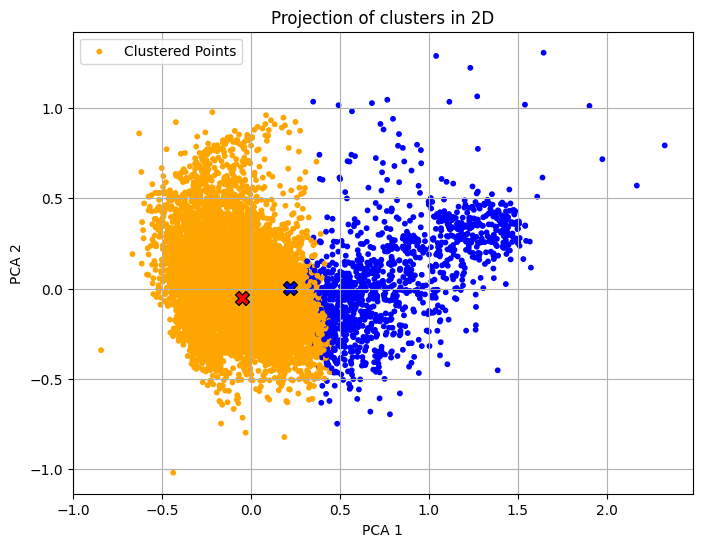

In [85]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 2)
kmeans.fit(compressed_train_data_peak)
compressed_test_labels = kmeans.predict(compressed_test_data_peak)

X_2d = PCA(n_components=2).fit_transform(compressed_test_data_peak)

custom_colors = ['blue', 'orange']
cluster_colors = [custom_colors[label] for label in compressed_test_labels]

healthy_indices = [10] # ,902,12,13,101,15,301,36,25,38
disease_indices = [80] # ,81,82,86,87,88,89,19,182,2003

plt.figure(figsize=(8, 6))
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=cluster_colors, s=10, label='Clustered Points')

highlighted_points = X_2d[healthy_indices]
plt.scatter(highlighted_points[:, 0], highlighted_points[:, 1], 
            color='blue', edgecolor='black', s=100, marker='X')

highlighted_points = X_2d[disease_indices]
plt.scatter(highlighted_points[:, 0], highlighted_points[:, 1], 
            color='red', edgecolor='black', s=100, marker='X')

plt.title("Projection of clusters in 2D")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.legend()
plt.show()

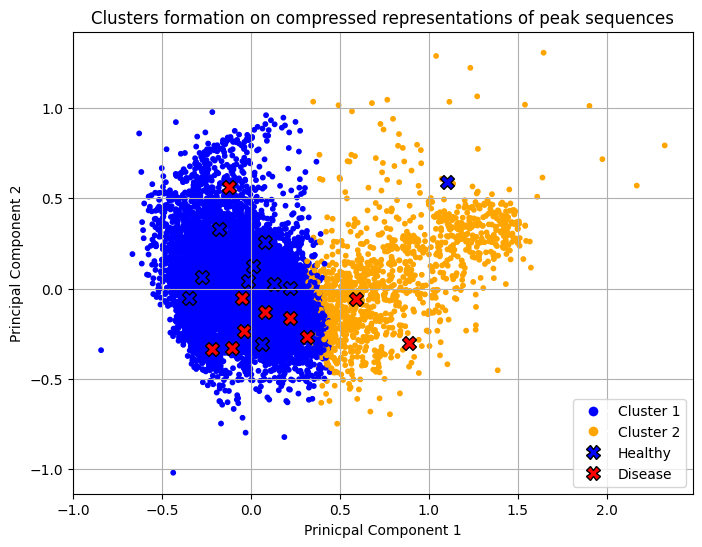

In [102]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# KMeans clustering
kmeans = KMeans(n_clusters=2)
kmeans.fit(compressed_train_data_peak)
compressed_test_labels = kmeans.predict(compressed_test_data_peak)

# PCA projection to 2D
X_2d = PCA(n_components=2).fit_transform(compressed_test_data_peak)

# Colors for clusters
custom_colors = ['blue', 'orange']
cluster_colors = [custom_colors[label] for label in compressed_test_labels]

# Highlighted points
healthy_indices = [10,902,12,13,101,15,301,36,25,38] 
disease_indices = [80,81,82,86,87,88,89,19,182,2003] 

plt.figure(figsize=(8, 6))

# Cluster points
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=cluster_colors, s=10)

# Healthy points
highlighted_healthy = X_2d[healthy_indices]
plt.scatter(highlighted_healthy[:, 0], highlighted_healthy[:, 1], 
            color='blue', edgecolor='black', s=100, marker='X')

# Disease points
highlighted_disease = X_2d[disease_indices]
plt.scatter(highlighted_disease[:, 0], highlighted_disease[:, 1], 
            color='red', edgecolor='black', s=100, marker='X')

plt.title("Clusters formation on compressed representations of peak sequences")
plt.xlabel("Prinicpal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)

# Custom legend
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Cluster 1', markerfacecolor='blue', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='Cluster 2', markerfacecolor='orange', markersize=8),
    Line2D([0], [0], marker='X', color='w', label='Healthy', markerfacecolor='blue', markeredgecolor='black', markersize=10),
    Line2D([0], [0], marker='X', color='w', label='Disease', markerfacecolor='red', markeredgecolor='black', markersize=10)
]

plt.legend(handles=legend_elements)
plt.show()


In [101]:
# Computing the Silhouette score

from sklearn.metrics import silhouette_score

score = silhouette_score(compressed_test_data_peak, compressed_test_labels, metric = "euclidean")
print("Silhouette Score: %.3f" %score)

Silhouette Score: 0.531


### 4rth model:  Reservoir + Clustering on peaks data

In [106]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

train_data_peaks = np.array(train_data_peaks)  
test_data_peaks = np.array(test_data_peaks)

scaler = MinMaxScaler()
X_train_scaled_peaks = scaler.fit_transform(train_data_peaks)
X_test_scaled_peaks = scaler.transform(test_data_peaks)

X_train_scaled_peaks = X_train_scaled_peaks.reshape(X_train_scaled_peaks.shape[0], X_train_scaled_peaks.shape[1], 1)
X_test_scaled_peaks = X_test_scaled_peaks.reshape(X_test_scaled_peaks.shape[0], X_test_scaled_peaks.shape[1], 1)

In [105]:
X_train_scaled_peaks.shape

(54127, 200, 1)

In [135]:
import numpy as np
import reservoirpy as rpy
from reservoirpy.nodes import Reservoir

rpy.verbosity(0)
rpy.set_seed(42)

# Definir rangos de hiperparámetros
units_list = [50, 100, 150, 200, 250, 300]
lr_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
sr_list = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5]

n_trials = 20  # número de combinaciones aleatorias a probar
best_score = -np.inf
best_params = None

for _ in range(n_trials):
    # Selección aleatoria de hiperparámetros
    units = np.random.choice(units_list)
    lr = np.random.choice(lr_list)
    sr = np.random.choice(sr_list)
    
    reservoir = Reservoir(units=units, lr=lr, sr=sr)
    
    all_states = []
    for timeserie in X_train_peaks_reservoir:
        reservoir.reset()
        states = reservoir.run(timeserie)
        all_states.append(states)
    
    training_features = np.array(all_states)
    
    # Métrica: varianza promedio de los estados del reservoir
    neuron_variances = np.var(training_features, axis=(0,1))
    score = np.mean(neuron_variances)
    
    if score > best_score:
        best_score = score
        best_params = {"units": units, "lr": lr, "sr": sr}

print("Best hyperparameters:", best_params)
print("Best score (mean variance):", best_score)

Best hyperparameters: {'units': np.int64(200), 'lr': np.float64(1.0), 'sr': np.float64(1.0)}
Best score (mean variance): 0.01989831751285259


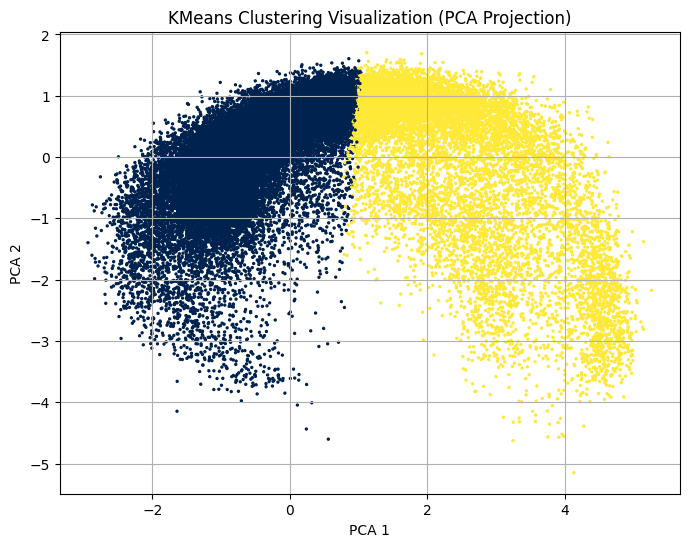

In [171]:
import reservoirpy as rpy
from reservoirpy.nodes import Reservoir

rpy.verbosity(0)
rpy.set_seed(42)

reservoir_def = Reservoir(units = 200, lr = 1, sr = 1)

all_states = []
for timeserie in X_train_peaks_reservoir: 
    reservoir_def.reset()
    states = reservoir_def.run(timeserie)
    all_states.append(states)

training_features = np.array(all_states)

training_features = training_features.reshape(training_features.shape[0], -1)

n_cluster = 2
kmeans = KMeans(n_clusters = n_cluster, random_state = 12)
train_labels = kmeans.fit_predict(training_features)

X_2d = PCA(n_components=2).fit_transform(training_features)

plt.figure(figsize=(8,6))
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=train_labels, cmap='cividis', s=2)

plt.title("KMeans Clustering Visualization (PCA Projection)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.show()

In [158]:
training_features.shape

(54127, 200)

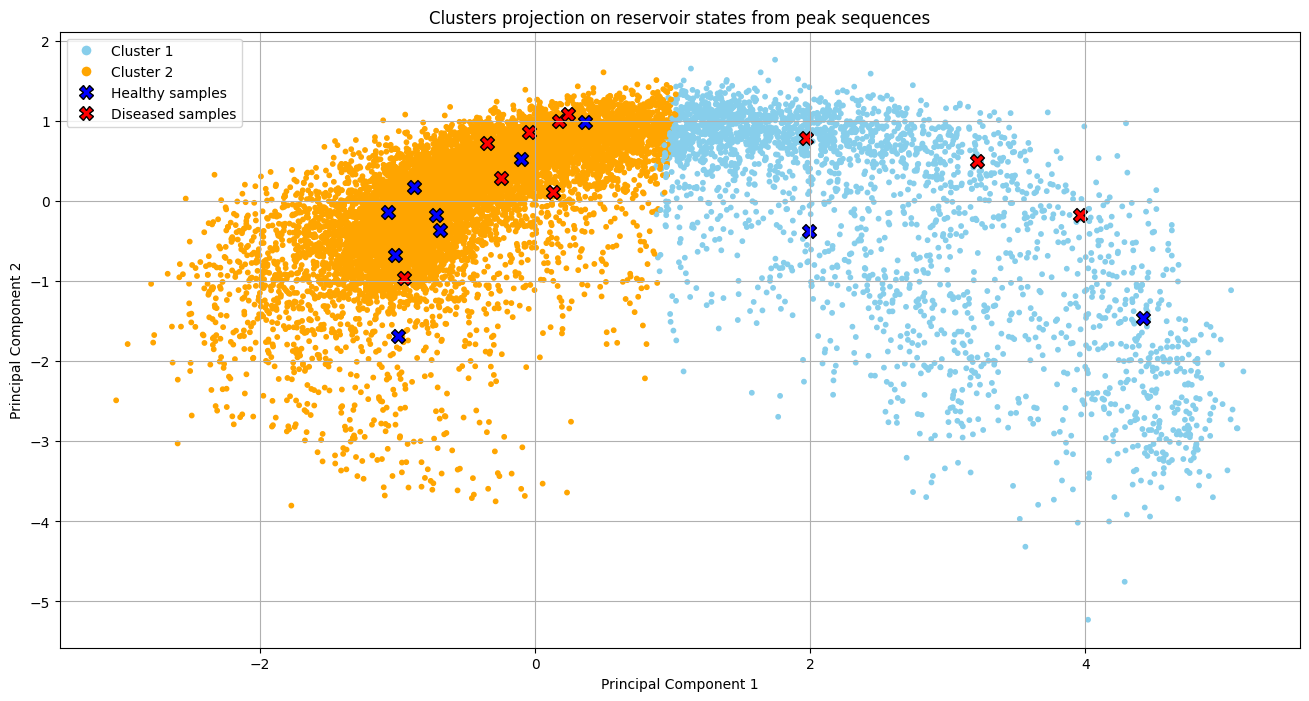

In [173]:
# Applying the reservoir to the test data

all_states_test = []
for timeserie in X_test_peaks_reservoir: 
    reservoir_def.reset()
    states = reservoir_def.run(timeserie)
    all_states_test.append(states)

test_features = np.array(all_states_test)

test_features = test_features.reshape(test_features.shape[0], -1)
test_labels = kmeans.predict(test_features)

X_2d = PCA(n_components=2).fit_transform(test_features)

plt.figure(figsize=(16,8))

healthy_indices = [10,902,12,13,101,15,301,36,25,38]
disease_indices = [80,81,82,86,87,88,89,19,182,2003] 

custom_colors = ['orange', 'skyblue']
cluster_colors = [custom_colors[label] for label in test_labels]
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=cluster_colors, s=10)


highlighted_points = X_2d[healthy_indices]
plt.scatter(highlighted_points[:, 0], highlighted_points[:, 1], 
            color='blue', edgecolor='black', s=100, marker='X')

highlighted_points = X_2d[disease_indices]
plt.scatter(highlighted_points[:, 0], highlighted_points[:, 1], 
            color='red', edgecolor='black', s=100, marker='X')

plt.title("Clusters projection on reservoir states from peak sequences")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)

# Custom legend
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Cluster 1', markerfacecolor='skyblue', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='Cluster 2', markerfacecolor='orange', markersize=8),
    Line2D([0], [0], marker='X', color='w', label='Healthy samples', markerfacecolor='blue', markeredgecolor='black', markersize=10),
    Line2D([0], [0], marker='X', color='w', label='Diseased samples', markerfacecolor='red', markeredgecolor='black', markersize=10)
]

plt.legend(handles=legend_elements)
plt.show()

In [174]:
score = silhouette_score(test_features, test_labels, metric = "euclidean")
print("Silhouette Score: %.3f" %score)

Silhouette Score: 0.461


### Comparing points in the boundaries

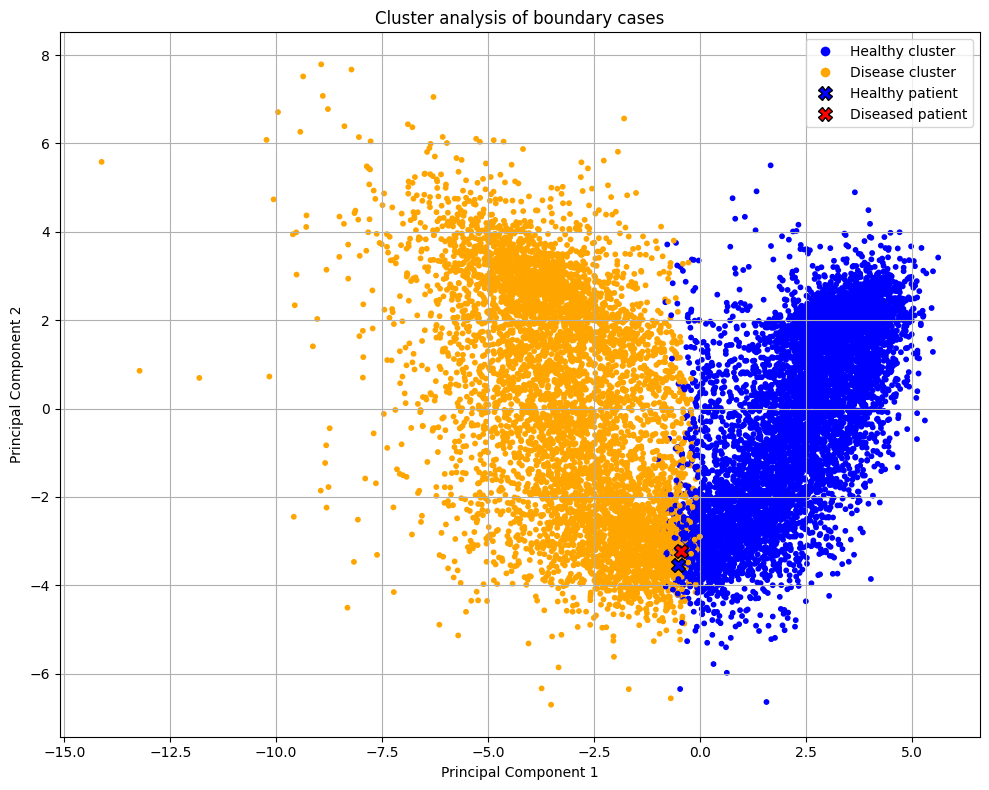

In [245]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 2)
kmeans.fit(compressed_train_data)
compressed_test_labels = kmeans.predict(compressed_test_data)

X_2d = PCA(n_components=2).fit_transform(compressed_test_data)

healthy_indices = [1420]
disease_indices = [1765]

custom_colors = ['blue', 'orange']
cluster_colors = [custom_colors[label] for label in compressed_test_labels]

plt.figure(figsize=(10,8))
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=cluster_colors, s=10, label='Clustered Points')

highlighted_points = X_2d[healthy_indices]
plt.scatter(highlighted_points[:, 0], highlighted_points[:, 1], 
            color='blue', edgecolor='black', s=100, marker='X')

highlighted_points = X_2d[disease_indices]
plt.scatter(highlighted_points[:, 0], highlighted_points[:, 1], 
            color='red', edgecolor='black', s=100, marker='X')

plt.title("Cluster analysis of boundary cases")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)

# Custom legend
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Healthy cluster', markerfacecolor='blue', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='Disease cluster', markerfacecolor='orange', markersize=8),
    Line2D([0], [0], marker='X', color='w', label='Healthy patient', markerfacecolor='blue', markeredgecolor='black', markersize=10),
    Line2D([0], [0], marker='X', color='w', label='Diseased patient', markerfacecolor='red', markeredgecolor='black', markersize=10)
]

plt.legend(handles=legend_elements)
plt.tight_layout()
plt.show()

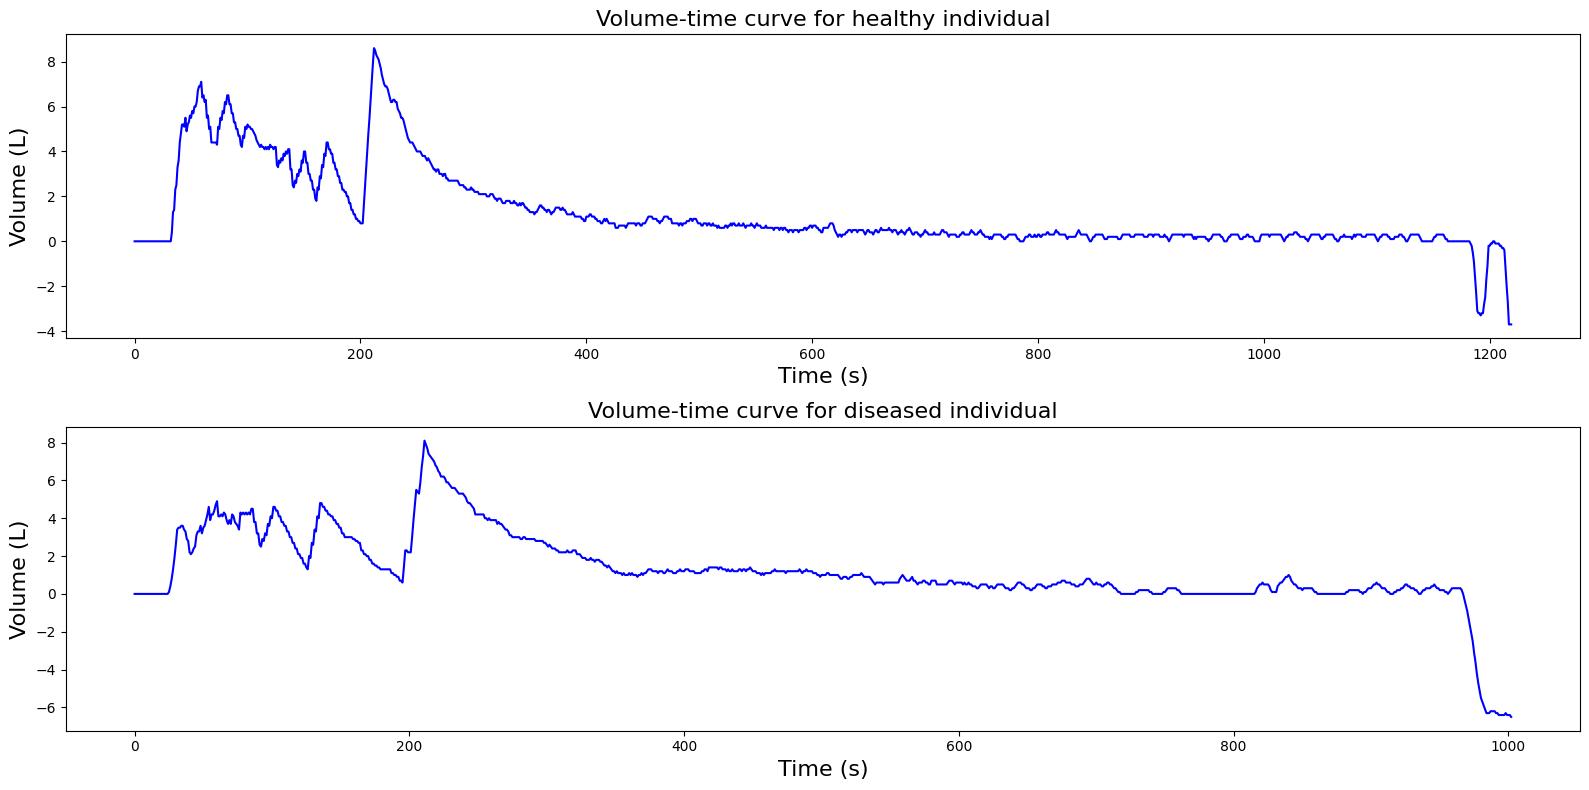

In [239]:
plt.figure(figsize=(16, 8))

[1420, 1765]

plt.subplot(211)
plt.plot(np.arange(split[1][1420].shape[0]), split[1][1420], label='Volume', color='blue')
plt.title('Volume-time curve for healthy individual', fontsize = 16)
plt.xlabel('Time (s)', fontsize = 16)
plt.ylabel('Volume (L)', fontsize = 16)

plt.subplot(212)
plt.plot(np.arange(split[1][1765].shape[0]), split[1][1765], label='Volume', color='blue')
plt.title('Volume-time curve for diseased individual', fontsize = 16)
plt.xlabel('Time (s)', fontsize = 16)
plt.ylabel('Volume (L)', fontsize = 16)

plt.tight_layout()
plt.show()